<h1 style="color:red"> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2  Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2> 1.3  Real world/Business Objectives and Constraints</div> </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1 style="color:red">2. Machine Learning Problem </h1>

<h2> 2.1 Data</div> </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem</div> </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction</div> </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1 style="color:red">3. Exploratory Data Analysis </h1>

<h3>3.1  Importing....</div></h3>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import plotly.tools as tls
import os
import gc
import random
import distance
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint as randint
from scipy.stats import uniform

import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer , SnowballStemmer
from fuzzywuzzy import fuzz
from collections import Counter, defaultdict

from sklearn.manifold import TSNE
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RFC
import xgboost as xgb

from wordcloud import WordCloud, STOPWORDS
from os import path
import spacy
import pickle
import time

#Deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Reshape,Flatten
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')


<h2 style="color:blue"> 4. Data Collection and quick Exploration</h2>

In [ ]:
data_frame = pd.read_csv("DATA/train.csv")

print("Number of data points:",data_frame.shape)
print(data_frame.columns)

In [12]:
data_frame.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [50]:
print(data_frame.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
None


$Observations...$ 

<p style="background-color:#E8FDC9;">
   1. There are 404290 entries(rows) and 6 features(columns) in the dataset  <br>
   2. The DataFrame has empty fields.Two entries in question1 and one entry in question2 are empty<br>
   3. The output class is "is_duplicate"  <br>
   4. is_duplicate == 0; question1 and question2 are Not duplicate <br>
   5. is_duplicate == 1; question1 and question2 are duplicate <br>
</p>
<br>
<div style="background-color:#E8FDC9;">

The 6 data features given to us are: <br>
id: Looks like a simple rowID <br>
qid{1, 2}: The unique ID of each question in the pair <br>
question{1, 2}: The actual textual contents of the questions.<br>
is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

</div>

<h3 style="color:blue"> 4.1 Distribution of data points among output classes</h3>

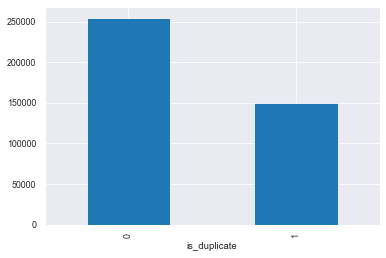

In [51]:
data_sep = data_frame.groupby("is_duplicate")['id'].count()
data_sep.plot.bar()

In [94]:
print('Duplicate Question Pairs :  {}%'.format(round(data_frame['is_duplicate'].mean()*100, 2)))

Duplicate Question Pairs :  36.92%


<b> Note : </b>


<div style="background-color:#E8FDC9">
1. There are about 63% of entries which belongs to output class "0"(not duplicate) and 37% belonging to class "1"(duplicate)   <br>
2. Thus we have an imbalanced dataset<br>
</div>

<h3 style="color:blue"> 4.2 Unique questions in data </h3>

In [ ]:
qidList = pd.Series(data_frame["qid1"].to_list() + data_frame["qid2"].to_list())
unique_ids =  len(np.unique(qidList))
qid_not_unique = np.sum(qidList.value_counts() > 1)

print ('Total number of  Unique Questions are: {}'.format(unique_ids))
print ('Number of unique questions that appear more than one time: {} ( which is {}%)'.format(qid_not_unique,qid_not_unique/unique_ids*100))
print ('Max number of times a single question is repeated: {}'.format(max(qidList.value_counts())))

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_ids , qid_not_unique]

plt.subplot(2,1,1)
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)

plt.subplot(2,1,2)
plt.figure(figsize=(10, 5))
plt.hist(qidList.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of unique questions')
plt.ylabel('Count')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qidList.value_counts()))) 

Maximum number of times a single question is repeated: 157



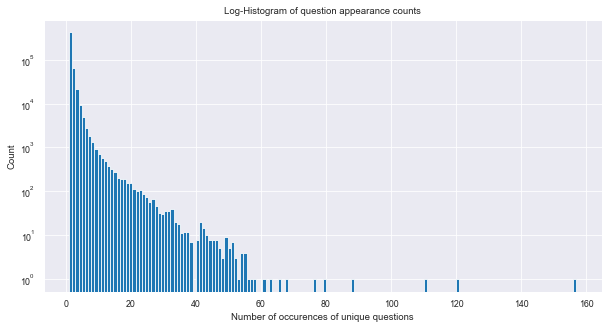

In [100]:
plt.figure(figsize=(10, 5))
plt.hist(qidList.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of unique questions')
plt.ylabel('Count')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qidList.value_counts()))) 

<div style="background-color:#E8FDC9">
<b>NOTE : </b> <br>
1. There are less no of Questions which are repeated lot of times and more questions which are less repeated.<br>
2. One of the question is repeted 157 times.

<h3 style="color:blue">4.3 No of unique Question "Pairs" </h3>

In [56]:
duplicate_pairs_list = data_frame[['qid1','qid2','is_duplicate']].groupby(['qid1' , 'qid2']).count().reset_index()
# print(duplicate_pairs)

duplicate_pairs = data_frame.shape[0] - duplicate_pairs_list.shape[0]
print("No of duplicate entries in the dataset {}".format(duplicate_pairs))

No of duplicate entries in the dataset 0


<div style="background-color:#E8FDC9">
<b> NOTE : </b><br> There are no duplicate entries in the dataset; All pairs of Questions are unique.<br>

<h3 style="color:blue"> 4.4 Missing Values?</h3>

In [92]:
#Checking whether there are any rows with null values
nan_rows = data_frame[data_frame.isnull().any(1)]
print(len(nan_rows))

3


<p style="background-color:#E8FDC9"> <b> NOTE : </b> There are two entries in column question2 and one entry in column question1 which has null values</p>

In [58]:
# Filling the null values with ' '
data_frame = data_frame.fillna(' ')
nan_rows = data_frame[data_frame.isnull().any(1)]

<h3 style="color:blue"> 4.5 Feature Extraction(Simple features) </h3>

<div style="background-color:#E8FDC9">
 Let us now construct a few features
 
    1.Frequency of question 1 and 2 ids
    2.Character length of questions 1 and 2
    3.Word Length of questions 1 and 2
    4.Number of words in question 1 and 2
    5.Normalized word share count.
    6.Sum and difference of frequencies of q1 and q2 ids

 
 
 
 
 
 - ____freq_qid1____ = Frequency of qid1's ids
 - ____freq_qid2____ = Frequency of qid2's ids
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_words____ = Number of words in Question 1
 - ____q2_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of unique words in Question 1 + Total num of unique words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 
   
</div>

In [60]:
def words_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) & len(w2))
    
def words_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
def word_Share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [61]:
data_frame['freq_qid1'] = data_frame.groupby('qid1')['qid1'].transform('count') 
data_frame['freq_qid2'] = data_frame.groupby('qid2')['qid2'].transform('count')
data_frame['q1len'] = data_frame['question1'].str.len() 
data_frame['q2len'] = data_frame['question2'].str.len()
data_frame['q1_words'] = data_frame['question1'].apply(lambda r: len(r.split(" ")))
data_frame['q2_words'] = data_frame['question2'].apply(lambda r: len(r.split(" ")))
data_frame['word_Common'] = data_frame.apply(words_Common, axis=1)
data_frame['word_Total'] = data_frame.apply(words_Total, axis=1)
data_frame['word_share'] = data_frame.apply(word_Share, axis=1)
data_frame["freq_q1+freq_q2"] = data_frame['freq_qid1'] + data_frame['freq_qid2']
data_frame["freq_q1-freq_q2"] = abs(data_frame['freq_qid1'] - data_frame['freq_qid2'])

In [62]:
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words', 'q2_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2'],
      dtype='object')

<h3> 4.6 Analysis of some of the Extracted Features </h3>

In [63]:
#Function for univariate analysis for extracted features
def plot_Univariate(A, B):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plot = sns.violinplot(x = A, y = B, data = data_frame[0:])
    plot.set_xticklabels(['0','1'])
    plt.subplot(1,2,2)
    sns.distplot(data_frame[data_frame[A] == 1.0][B][0:] , label = "1", color = 'yellow')
    sns.distplot(data_frame[data_frame[A] == 0.0][B][0:] , label = "0" , color = 'green' )
    plt.legend()
    plt.show()

<h4> 4.6.1 Feature: Word Share </h3>

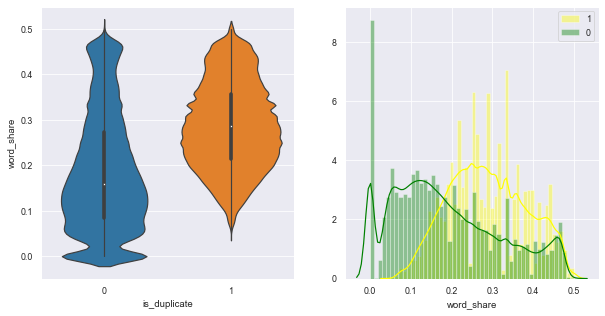

In [64]:
plot_Univariate('is_duplicate','word_share');

<h4>Observations:</h4>
<p>1. The two output classes have  some amount of separatability on some ranges of values of the random variable "word_share".Hence the feature have some information to  provide and hence is useful </p>
<p>2. word_share>0.2 is  more commonly seen in positive class than in the negative class and word_share < 0.2 is commonly seen in negative class than in positive class</p>

<h4> 4.6.2 Feature: Word Common </h3>

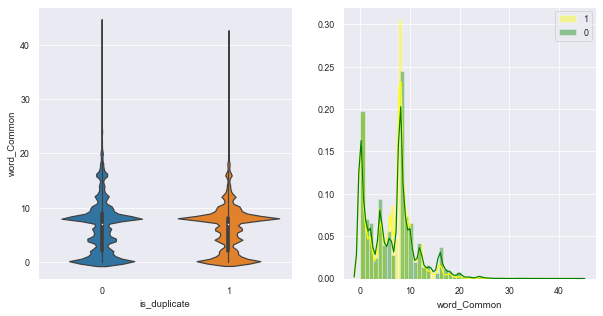

In [65]:
plot_Univariate('is_duplicate','word_Common');


<h4>Observations:</h4>
<p>1. Here the two output classes have  very little separatability(i.e  the distribution of the two classes are highly overlapping ) which can  also be seen in the violin plots.However, the feature can still provide some information and hence can improve the models we will be using in the future </p>


<h4> 4.6.3 Feature: Word Total </h3>

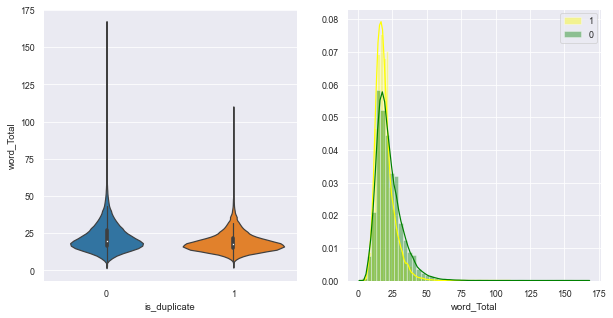

In [66]:
plot_Univariate('is_duplicate','word_Total');

<h4>Observations:</h4>
<p>1. Here  also the two output classes have  some separatability on a range of values of the random variable "word_Total" which can be seen in the violin plots.Hence this feature can also provide some information to the models </p>


<h3>Similarly we plot the univariate analysis  for our remaining extrated features:</h3>

-freq_q1-freq_q2 <br>
-freq_q1+freq_q2<br>
-q2_words<br>
-q1_words<br>
-q1len<br>
-q2len<br>
-freq_qid1<br>
-freq_qid2 <br>

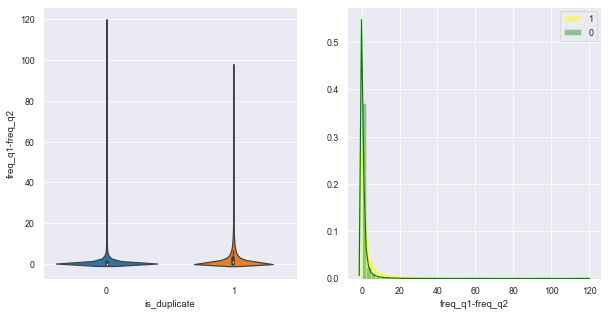

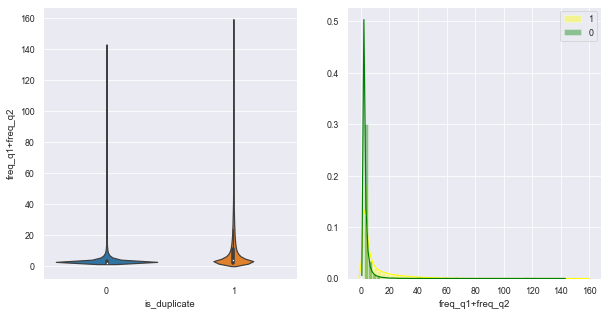

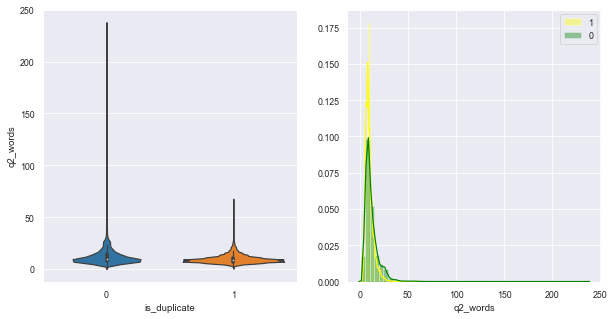

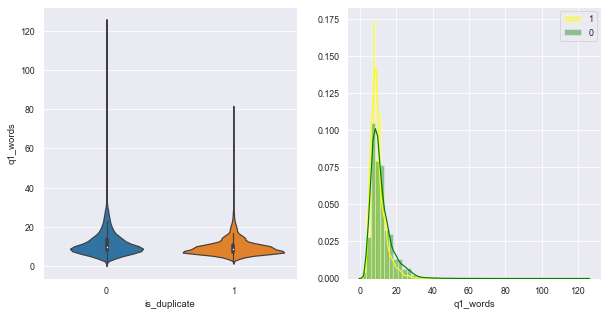

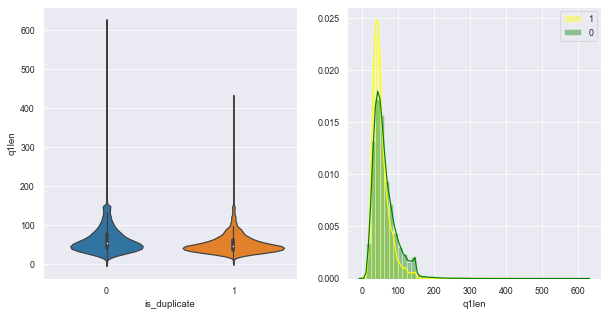

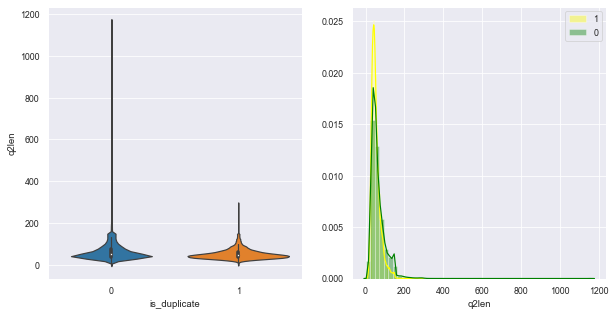

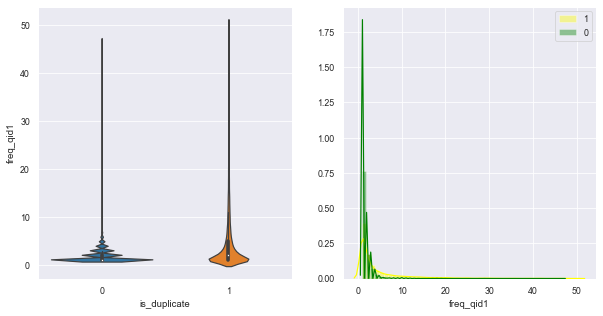

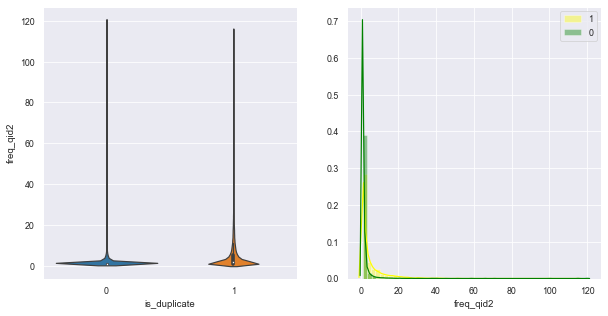

In [67]:
plot_Univariate('is_duplicate','freq_q1-freq_q2');
plot_Univariate('is_duplicate','freq_q1+freq_q2');
plot_Univariate('is_duplicate','q2_words');
plot_Univariate('is_duplicate','q1_words');
plot_Univariate('is_duplicate','q1len');
plot_Univariate('is_duplicate','q2len');
plot_Univariate('is_duplicate','freq_qid1');
plot_Univariate('is_duplicate','freq_qid2');

In [68]:
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words', 'q2_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2'],
      dtype='object')

<h1 style="color:blue"> 4.7 Preprocessing:</h1>
    <p style="background-color:#E8FDC9">
    - Removing html tags <br>
    - Removing Punctuations<br>
    - Performing stemming<br>
    - Removing Stopwords<br>
    - Expanding contractions etc.</p>

In [4]:
#removing stop  words
STOP_WORDS = stopwords.words("english")

def preprocessing(feat):
    #simple pre-processing
    feat = str(feat).lower()
    feat = feat.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    feat = re.sub(r"([0-9]+)000000", r"\1m", feat)
    feat = re.sub(r"([0-9]+)000", r"\1k", feat)
    
    #Stemming
    s = SnowballStemmer('english')
    pattern = re.compile('\W')
    
    if type(feat) == type('abc'):
        feat = re.sub(pattern, ' ', feat)
        feat = s.stem(feat)
        
    return feat

<h2 style="color: blue"> 4.8 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

<div>
Definition:<br>
1. Token: You get a token by splitting sentence a space<br>
2. Stop_Word : stop words as per NLTK.<br>
3. Word : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [70]:
SAFE_DIV = 0.0001 

def getFeatures(X , Y):
    features = [0.0]*10
    # Converting the Sentence into Tokens: 
    q1_tokens = X.split()
    q2_tokens = Y.split()
    #Since all features have about common strings , if len of any question is 0,no of common words is 0 , so we return 0
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return features 
    #words in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])  
    #stopwords in Questions
    q1_stop_words = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stop_words = set([word for word in q2_tokens if word in STOP_WORDS])
    # Getting the common words, stopwords and token from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stop_words.intersection(q2_stop_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    #FEATURES EXTRACTED
    features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    features[2] = common_stop_count / (min(len(q1_stop_words), len(q2_stop_words)) + SAFE_DIV)
    features[3] = common_stop_count / (max(len(q1_stop_words), len(q2_stop_words)) + SAFE_DIV)
    features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV) 
    features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    features[7] = int(q1_tokens[0] == q2_tokens[0])    
    features[8] = abs(len(q1_tokens) - len(q2_tokens))
    features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return features

def fetch_LCSR(A, B):  #longest common substring ratio
    lc_str = list(distance.lcsubstrings(A, B))
    if len(lc_str) == 0:
        return 0
    else:
        return len(lc_str[0]) / (min(len(A), len(B)) + 1)

def extract_features(data_frame):
    # preprocessing each question
    data_frame["question1"] = data_frame["question1"].apply(preprocessing)
    data_frame["question2"] = data_frame["question2"].apply(preprocessing)
    print("token features...")
    token_features = data_frame.apply(lambda x: getFeatures(x["question1"], x["question2"]), axis=1)
    
    data_frame["cwc_min"]       = list(map(lambda x: x[0], token_features))
    data_frame["cwc_max"]       = list(map(lambda x: x[1], token_features))
    data_frame["csc_min"]       = list(map(lambda x: x[2], token_features))
    data_frame["csc_max"]       = list(map(lambda x: x[3], token_features))
    data_frame["ctc_min"]       = list(map(lambda x: x[4], token_features))
    data_frame["ctc_max"]       = list(map(lambda x: x[5], token_features))
    data_frame["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    data_frame["first_word_eq"] = list(map(lambda x: x[7], token_features))
    data_frame["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    data_frame["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings  
    print("fuzzy features..")
    data_frame["token_set_ratio"]       = data_frame.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    data_frame["token_sort_ratio"]      = data_frame.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    data_frame["fuzz_ratio"]            = data_frame.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    data_frame["fuzz_partial_ratio"]    = data_frame.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    data_frame["longest_substr_ratio"]  = data_frame.apply(lambda x: fetch_LCSR(x["question1"], x["question2"]), axis=1)
    return data_frame
    

In [71]:
data_frame = extract_features(data_frame)
data_frame.columns

token features...
fuzzy features..


Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words', 'q2_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [72]:
if os.path.isfile('DATA/advanced_features_dataframe.csv'):
    data_frame = pd.read_csv("DATA/advanced_features_dataframe.csv")
else:
    data_frame.to_csv("DATA/advanced_features_dataframe.csv", index=False)

<h3 style="color:blue">4.9 Analysis of extracted features </h3>

<h4>4.9.1  Pair plot of features {'ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'}</h4>

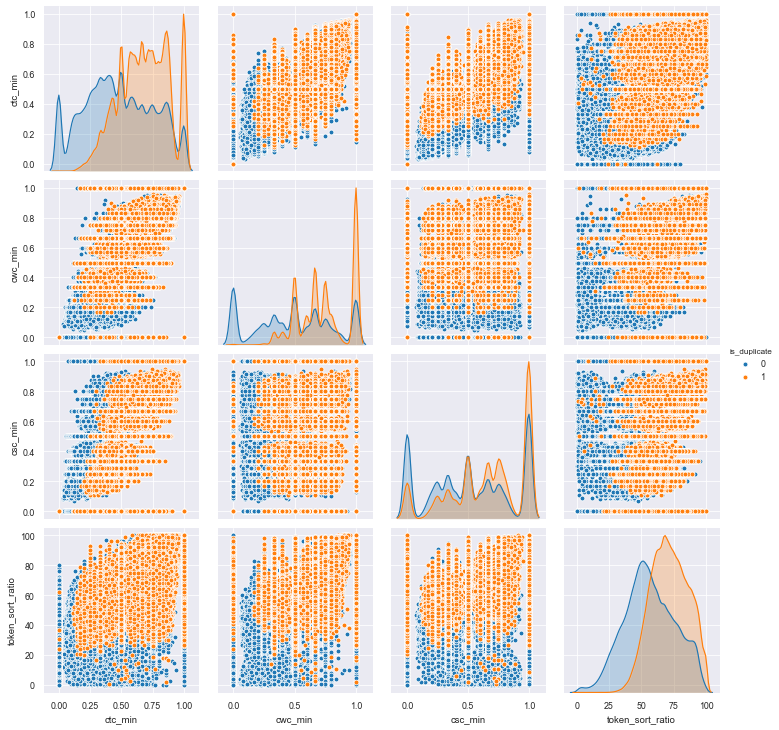

In [74]:
sns.pairplot(data_frame[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<h4>4.9.2  Pair plot of features {'ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio'}</h4>

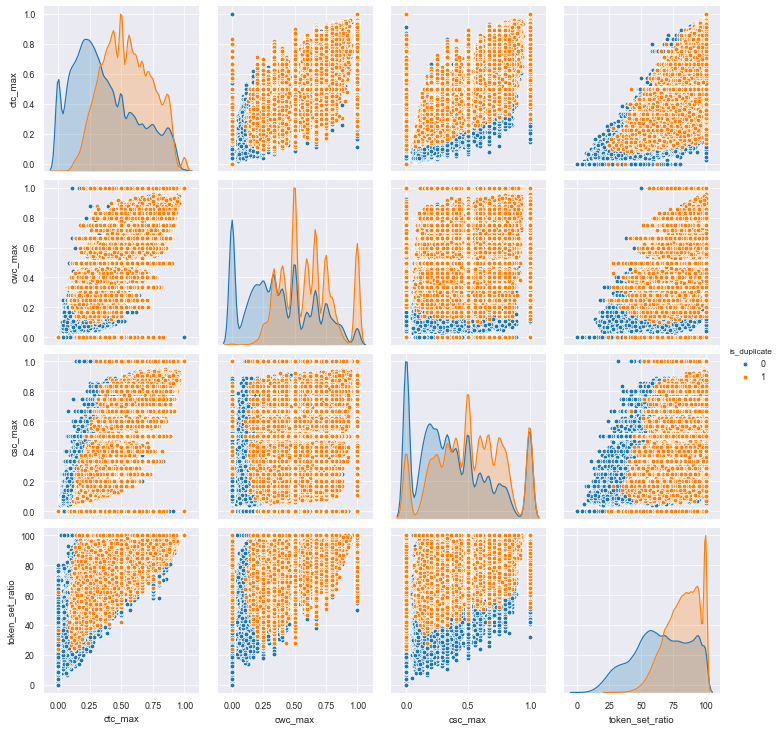

In [75]:
sns.pairplot(data_frame[['ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate', vars=['ctc_max', 'cwc_max', 'csc_max', 'token_set_ratio'])
plt.show()

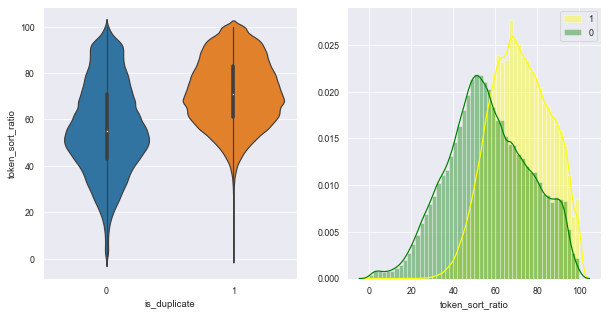

In [76]:
#token sort ratio univariate analysis
plot_Univariate("is_duplicate","token_sort_ratio")

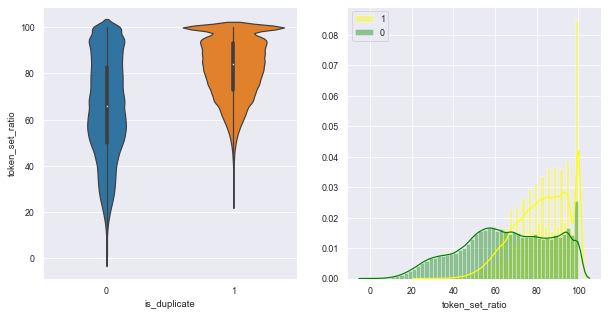

In [77]:
#token sort ratio univariate analysis
plot_Univariate("is_duplicate","token_set_ratio")

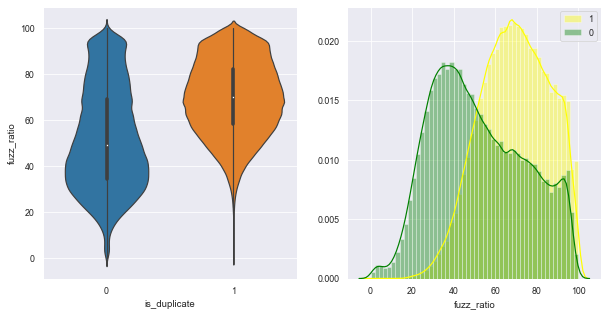

In [78]:
#token sort ratio univariate analysis
plot_Univariate("is_duplicate","fuzz_ratio")

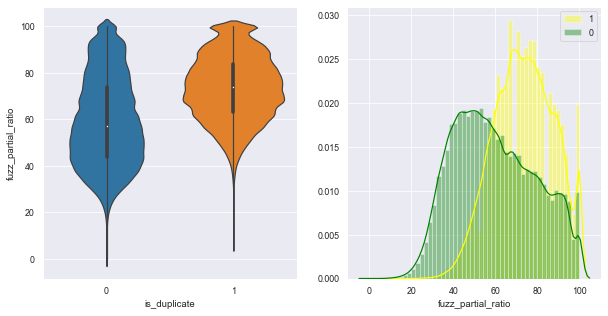

In [79]:
#token sort ratio univariate analysis
plot_Univariate("is_duplicate","fuzz_partial_ratio")

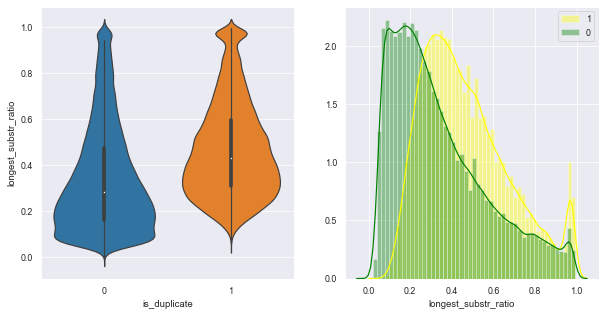

In [80]:
#longest subString ratio univariate analysis
plot_Univariate("is_duplicate","longest_substr_ratio")

$Observations..$

--> There are some amount of separatibility of the two classes for all the advance features.

<h3 style="color:blue">5.0 Visualization </h3>

In [81]:
# Using TSNE for Dimentionality reduction for 15 Extracted Features to 2 dimention
from sklearn.preprocessing import MinMaxScaler

dfsampled = data_frame[0:5000]
X = MinMaxScaler().fit_transform(dfsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfsampled['is_duplicate'].values

<h3> 5.1 Using TSNE for Dimentionality reduction for 15 Extracted Features (to 2 dimension)</h3>


In [82]:
tsneModel = TSNE(
    n_components = 2,
    init='random', # pca
    random_state = 100,
    method = 'barnes_hut',
    n_iter = 1000,
    verbose = 2,
    angle = 0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.208s...
[t-SNE] Computed neighbors for 5000 samples in 0.414s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131927
[t-SNE] Computed conditional probabilities in 0.313s
[t-SNE] Iteration 50: error = 81.8315506, gradient norm = 0.0426172 (50 iterations in 2.412s)
[t-SNE] Iteration 100: error = 70.6288376, gradient norm = 0.0087053 (50 iterations in 1.544s)
[t-SNE] Iteration 150: error = 68.7985840, gradient norm = 0.0066564 (50 iterations in 1.462s)
[t-SNE] Iteration 200: error = 67.9806976, gradient norm = 0.0037602 (50 iterations in 1.443s)
[t-SNE] Iteration 250: error = 67.5311584, gradient norm = 0.0032308

In [83]:
#https://stackoverflow.com/questions/39462433/stacking-arrays-in-numpy-using-vstack
Data_model = np.vstack((tsneModel.T,y[:,None].T)).T
Data_model.shape

(5000, 3)

In [84]:
Data_Model_TSNE = pd.DataFrame(Data_model, columns = ('TSNE_DIM_1','TSNE_DIM_2','is_duplicate'))

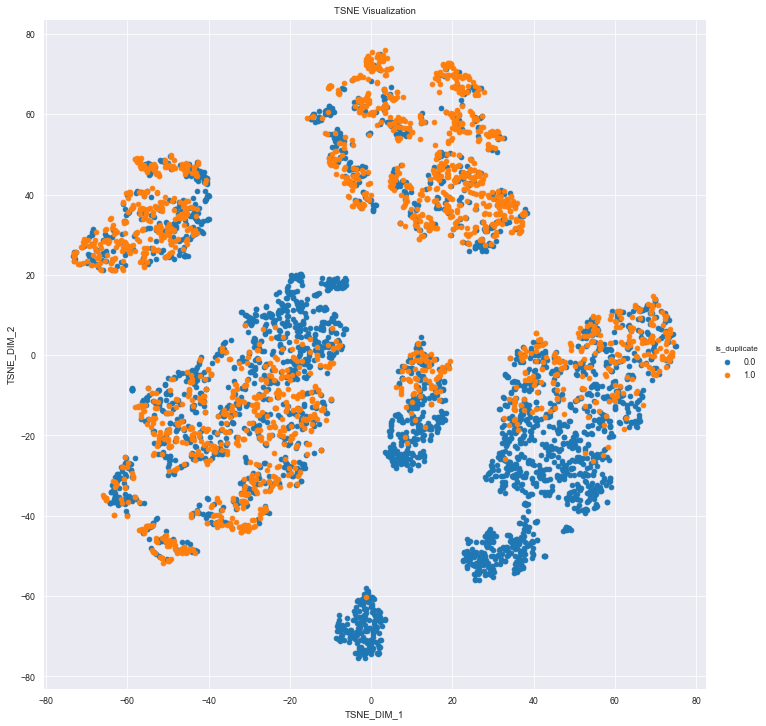

In [85]:
visual = sns.FacetGrid( Data_Model_TSNE, hue = "is_duplicate", size = 10)
visual.map(plt.scatter, "TSNE_DIM_1", "TSNE_DIM_2")
visual.add_legend()
plt.title("TSNE Visualization")
plt.show()

<h3>5.2 Using TSNE for Dimentionality reduction for 15 Extracted Features (to 3 dimension)</h3>


In [86]:
tsneModel2 = TSNE(
    n_components=3,
    init='random', # pca
    random_state=100,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 0.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131927
[t-SNE] Computed conditional probabilities in 0.261s
[t-SNE] Iteration 50: error = 81.9502258, gradient norm = 0.0386097 (50 iterations in 5.763s)
[t-SNE] Iteration 100: error = 69.6746674, gradient norm = 0.0036396 (50 iterations in 3.256s)
[t-SNE] Iteration 150: error = 68.1248245, gradient norm = 0.0018272 (50 iterations in 2.942s)
[t-SNE] Iteration 200: error = 67.5194473, gradient norm = 0.0012207 (50 iterations in 4.168s)
[t-SNE] Iteration 250: error = 67.1910782, gradient norm = 0.0010097

In [87]:
#https://stackoverflow.com/questions/39462433/stacking-arrays-in-numpy-using-vstack
Data_model2 = np.vstack((tsneModel2.T,y[:,None].T)).T
Data_model2.shape

(5000, 4)

In [40]:
Data_Model_TSNE2 = pd.DataFrame(Data_model2, columns = ('TSNE_DIM_1','TSNE_DIM_2','TSNE_DIM_3','is_duplicate'))

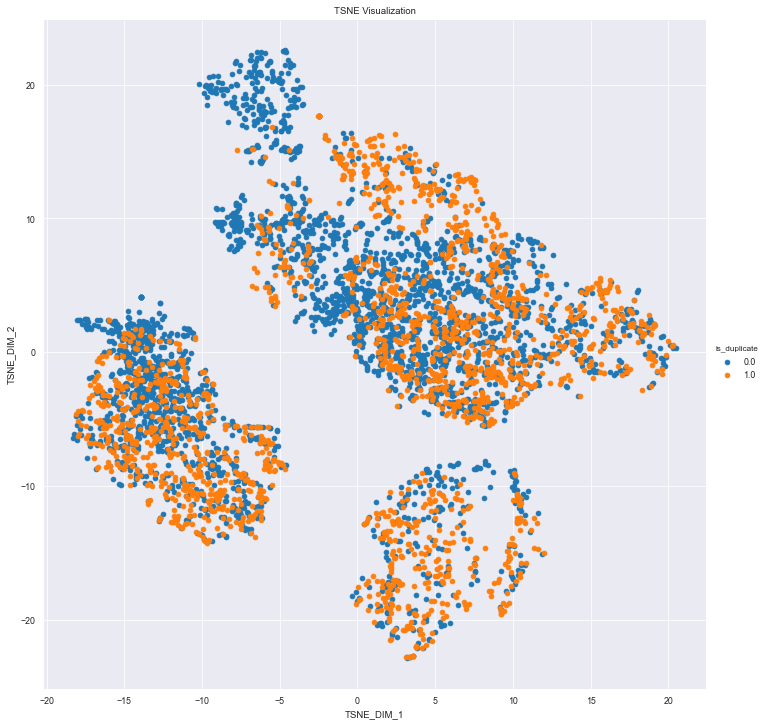

In [41]:
visual = sns.FacetGrid( Data_Model_TSNE2, hue = "is_duplicate", size = 10)
visual.map(plt.scatter, "TSNE_DIM_1", "TSNE_DIM_2")
visual.add_legend()
plt.title("TSNE Visualization")
plt.show()

<h2 style="color:blue"> 6. Preparing Data for Models</h2>

<h4> 6.1 Featurizing text data with tfidf weighted word-vectors </h4>

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

merged_qns = list(data_frame['question1']) + list(data_frame['question2'])
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(merged_qns)

idf_vals = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [66]:
import spacy as sp
# import en_core_web_lg
glove_model = sp.load('en_core_web_lg')

<h4> 6.1.1. Tfidf weighted w2v for question1 </h4>

In [91]:
vec_final1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for q1 in tqdm(list(data_frame['question1'])):
    glove_vector = glove_model(q1) 
    mean_vec1 = np.zeros([len(glove_vector), 300])   #300 is the number of dimensions of vectors 
    for word1 in glove_vector:
        vec1 = word1.vector  # word2vec
        # fetch df score
        try:
            idf = idf_vals[str(word1)]
        except:
            idf = 0
        # compute final vec
        tfidf_w2v = vec1 * idf
        mean_vec1 += tfidf_w2v
    mean_vec1 = mean_vec1.mean(axis=0)
    vec_final1.append(mean_vec1)
data_frame['q1_feat_tfidfw2v'] = list(vec_final1)

100%|████████████████████████████████| 404290/404290 [1:08:49<00:00, 97.91it/s]


NameError: name 'elist' is not defined

<h4> 6.1.2. Tfidf weighted w2v for question1 </h4>

In [93]:

vec_final2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for q2 in tqdm(list(data_frame['question2'])):
    glove_vector = glove_model(q2) 
#   384 is the number of dimensions of vectors 
    mean_vec2 = np.zeros([len(glove_vector), 300])
    for word2 in glove_vector:
        # word2vec
        vec2 = word1.vector
        # fetch df score
        try:
            idf = idf_vals[str(word2)]
        except:
            idf = 0
        # compute final vec
#         print(idf)
        tfidf_w2v = vec2 * idf
        mean_vec2 += tfidf_w2v
    mean_vec2 = mean_vec2.mean(axis=0)
    vec_final2.append(mean_vec1)
data_frame['q2_feat_tfidfw2v'] = list(vec_final2)

100%|████████████████████████████████| 404290/404290 [1:08:38<00:00, 98.16it/s]


<h4> 6.1.3. Preparing and Merging the vectors to the Dataframe </h4>

In [94]:
data_frame.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words', 'q2_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1_feat_tfidfw2v',
       'q2_feat_tfidfw2v'],
      dtype='object')

In [96]:
df1_vectors = pd.DataFrame(data_frame.q1_feat_tfidfw2v.values, index= data_frame.index)
df2_vectors = pd.DataFrame(data_frame.q2_feat_tfidfw2v.values, index= data_frame.index)

df1_vectors["id"] =  data_frame["id"]
df2_vectors["id"] =  data_frame["id"]

df_features  = data_frame.merge(df1_vectors, on='id',how='left')
df_features  = df_features.merge(df2_vectors, on='id',how='left')

In [81]:
if os.path.isfile('DATA/new_features_vectors.csv'):
    df_features = pd.read_csv("DATA/new_features_vectors.csv")
else:
    df_features.to_csv("DATA/new_features_vectors.csv", index=False)
df_features.head()

,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_words,q2_words,word_Common,word_Total,word_share,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,1,1,66,57,14,12,8.0,23.0,0.434783,...,3.420346,2.440726,-5.620145,2.717611,3.057584,2.666915,-3.831323,-3.157626,0.136943,6.200444
1,0,4,1,51,88,8,13,8.0,20.0,0.200000,...,3.420346,2.440726,-5.620145,2.717611,3.057584,2.666915,-3.831323,-3.157626,0.136943,6.200444
2,0,1,1,73,59,14,10,10.0,24.0,0.166667,...,3.420346,2.440726,-5.620145,2.717611,3.057584,2.666915,-3.831323,-3.157626,0.136943,6.200444
3,0,1,1,50,65,11,9,8.0,19.0,0.000000,...,3.420346,2.440726,-5.620145,2.717611,3.057584,2.666915,-3.831323,-3.157626,0.136943,6.200444
4,0,3,1,76,39,13,7,5.0,20.0,0.100000,...,3.420346,2.440726,-5.620145,2.717611,3.057584,2.666915,-3.831323,-3.157626,0.136943,6.200444


In [72]:
df_features.shape

(404290, 627)

<h4> 6.1.4. Sampling the data because of memory and computation limitations </h4>

In [82]:
#https://stackoverflow.com/a/22259008/4084039
#size of data is reduced to 200000 due to limitations of system configuration.Also the  data is sampled randomly.
# columns  = list(df_features.columns)
len_data =  df_features.shape[0]
sample_size = 300000 #desired sample size
skipped_data = sorted(random.sample(range(1 , len_data + 1) , len_data - sample_size))

print("Number of rows  :", len_data)
print("Number of rows to be eliminated :",len(skipped_data))

df_features = pd.read_csv('DATA/new_features_vectors.csv', skiprows = skipped_data)
print("Data size after sampling",df_features.shape)

Number of rows  : 404290
Number of rows to be eliminated : 104290
Data size after sampling (300000, 627)


In [5]:
y = df_features["is_duplicate"]
X = df_features.drop(["is_duplicate"],axis = 1)

In [6]:
print("Shape of final feature vector = ",X.shape)
print("Shape of final class(output) vector = ",y.shape)

Shape of final feature vector =  (200000, 626)
Shape of final class(output) vector =  (200000,)


<h2 style = "color:blue"> 6.2 Random train test split </h2>

In [7]:
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=100)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3,random_state=100)

In [8]:
print("Number of points in training data :",X_train.shape)
print("Number of points in test data :",X_test.shape)
print("Number of points in cross-validation data :",X_cv.shape)

Number of points in training data : (98000, 626)
Number of points in test data : (60000, 626)
Number of points in cross-validation data : (42000, 626)


In [27]:
tr_dist = Counter(y_train)
te_dist = Counter(y_test)
print("*"*10,"Distribution of output variable in train data"," Class 0:",int(tr_dist[0])/len(X_train)," Class 1:",int(tr_dist[1])/len(X_train),"*"*7)
print("*"*10,"Distribution of output variable in test data"," Class 0:",int(te_dist[0])/len(X_test)," Class 1:",int(te_dist[1])/len(X_train),"*"*7)

********** Distribution of output variable in train data  Class 0: 0.6319795918367347  Class 1: 0.3680204081632653 *******
********** Distribution of output variable in test data  Class 0: 0.632  Class 1: 0.2253061224489796 *******


In [50]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
  
    plt.figure(figsize=(10,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2 style = "color:blue"> 7. Models: </h2>
<h3> 7.1 Building a random model (Finding worst-case log-loss) </h3>

Log loss on Test Data using Random Model 0.8903015235678703


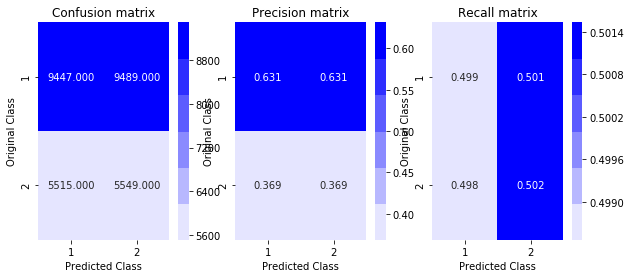

In [29]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

y_pred = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    prob_random = np.random.rand(1,2)
    y_pred[i] = (prob_random/sum(sum(prob_random)))[0]
print("Log loss on Test Data using Random Model",log_loss(y_test, y_pred, eps=1e-15))

y_pred =np.argmax(y_pred, axis=1) #we get 0 or 1 randomly on the basis os max value at that axis(1/2 prob each)
plot_confusion_matrix(y_test, y_pred)

<h3> 7.2 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4495382893400318
For values of alpha =  0.0001 The log loss is: 0.4384768386553954
For values of alpha =  0.001 The log loss is: 0.42824654163294473
For values of alpha =  0.01 The log loss is: 0.4230446619851432
For values of alpha =  0.1 The log loss is: 0.43359463125243025
For values of alpha =  1 The log loss is: 0.4566782959542931
For values of alpha =  10 The log loss is: 0.48671643213964144


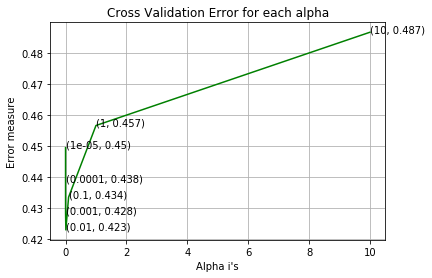

In [13]:
a_hype = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error = []
for item in a_hype:
    clf = SGDClassifier(alpha=item, penalty='l2', loss='log', random_state=100)
    cal_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    cal_sig_clf.fit(X_train, y_train)
    y_pred = cal_sig_clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv, y_pred, eps=1e-15))
    print('For values of alpha = ', item, "The log loss is:",log_loss(y_cv, y_pred, eps=1e-15))

#plotting
fig, ax = plt.subplots()
ax.plot(a_hype, log_error,c='g')
for i, txt in enumerate(np.round(log_error,3)):
    ax.annotate((a_hype[i],np.round(txt,3)), (a_hype[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train data log loss is: 0.4100975738345504
For values of best alpha =  0.01 ,The test data log loss is: 0.41773225867168423
Total number of data points : 30000


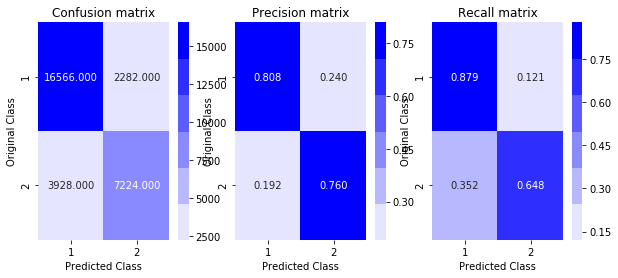

In [14]:
#Evaluating model on optimal hyperparameter
optimal_alpha = np.argmin(log_error)
clf = SGDClassifier(alpha=a_hype[optimal_alpha], penalty='l2', loss='log', random_state=100)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

y_pred_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', a_hype[optimal_alpha], "The train data log loss is:",log_loss(y_train, y_pred_train,eps=1e-15))
y_pred_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', a_hype[optimal_alpha], ",The test data log loss is:",log_loss(y_test, y_pred_test,eps=1e-15))
predicted_y =np.argmax(y_pred_test,axis=1) #predict_proba gives P(class1)and p(class2); so we take class1 
#if P(class1)>P(class2) and class2 if P(class1)<P(class2).
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y) #for test data

<h3> 7.3 Linear SVM with hyperparameter tuning (l2 regularization)</h2>

For values of alpha =  1e-05 The log loss is: 0.4288568494247511
For values of alpha =  0.0001 The log loss is: 0.43249466443755097
For values of alpha =  0.001 The log loss is: 0.44978503568190925
For values of alpha =  0.01 The log loss is: 0.42543524868215943
For values of alpha =  0.1 The log loss is: 0.4255456139423879
For values of alpha =  1 The log loss is: 0.44090784619403667
For values of alpha =  10 The log loss is: 0.47056469521474825


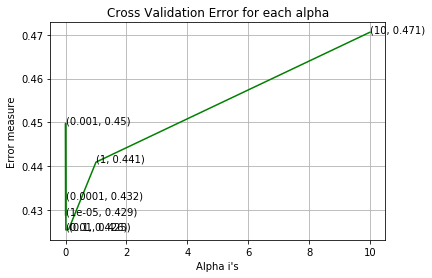

In [29]:
a_hype = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error=[]
for item in a_hype:
    clf = SGDClassifier(alpha=item, penalty='l2', loss='hinge', random_state=100)
    cal_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    cal_sig_clf.fit(X_train, y_train)
    y_pred = cal_sig_clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv, y_pred, eps=1e-15))
    print('For values of alpha = ', item, "The log loss is:",log_loss(y_cv, y_pred, eps=1e-15))

#plotting
fig, ax = plt.subplots()
ax.plot(a_hype, log_error,c='g')
for i, txt in enumerate(np.round(log_error,3)):
    ax.annotate((a_hype[i],np.round(txt,3)), (a_hype[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train data log loss is: 0.4141546354243661
For values of best alpha =  0.01 ,The test data log loss is: 0.42002163635555234
Total number of data points : 30000


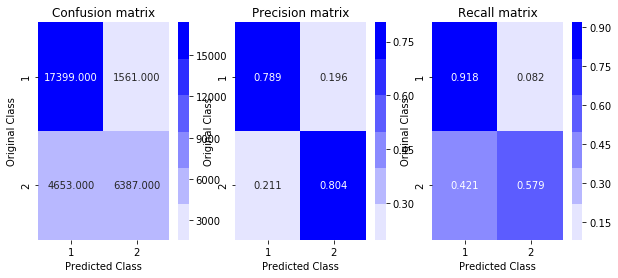

In [30]:
optimal_alpha = np.argmin(log_error)
clf = SGDClassifier(alpha=a_hype[optimal_alpha], penalty='l2', loss='hinge', random_state=100)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

y_pred_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', a_hype[optimal_alpha], "The train data log loss is:",log_loss(y_train, y_pred_train,eps=1e-15))
y_pred_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', a_hype[optimal_alpha], ",The test data log loss is:",log_loss(y_test, y_pred_test,eps=1e-15))
predicted_y =np.argmax(y_pred_test,axis=1) #predict_proba gives P(class1)and p(class2); so we take class1 
#if P(class1)>P(class2) and class2 if P(class1)<P(class2).
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y) #for test data

<h3> 7.4 Linear SVM with hyperparameter tuning (l1 regularization)</h2>

  0%|                                                    | 0/7 [00:00<?, ?it/s]

For values of alpha =  1e-05 The train log loss is: 0.4370399802361471 The cv log loss is: 0.4444067255612279


 14%|██████▏                                    | 1/7 [02:56<17:39, 176.60s/it]

For values of alpha =  0.0001 The train log loss is: 0.4377638425326896 The cv log loss is: 0.4457121066026968


 29%|████████████▎                              | 2/7 [13:49<26:36, 319.35s/it]

For values of alpha =  0.001 The train log loss is: 0.5076659780399313 The cv log loss is: 0.5128175110568493


 43%|██████████████████▍                        | 3/7 [26:07<29:40, 445.23s/it]

For values of alpha =  0.01 The train log loss is: 0.5288050214523147 The cv log loss is: 0.5340071263648779


 57%|████████████████████████▌                  | 4/7 [41:53<29:45, 595.28s/it]

For values of alpha =  0.1 The train log loss is: 0.4933224117511566 The cv log loss is: 0.49663612654653505


 71%|██████████████████████████████▋            | 5/7 [54:40<21:33, 646.82s/it]

For values of alpha =  1 The train log loss is: 0.5204743876307706 The cv log loss is: 0.522309924231794


 86%|████████████████████████████████████▊      | 6/7 [56:36<08:07, 487.72s/it]

For values of alpha =  10 The train log loss is: 0.6505682710488833 The cv log loss is: 0.6507959625284322


100%|███████████████████████████████████████████| 7/7 [57:47<00:00, 495.41s/it]


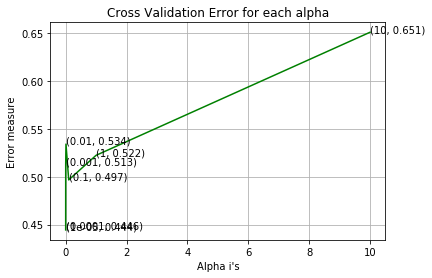

In [31]:
a_hype = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error=[]
for item in tqdm(a_hype):
    clf = SGDClassifier(alpha=item, penalty='l1', loss='hinge', random_state=100, n_jobs = -1,max_iter=2000)
    clf.fit(X_train, y_train)
    cal_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    cal_sig_clf.fit(X_train, y_train)
    y_pred = cal_sig_clf.predict_proba(X_cv)
    y_pred_train = cal_sig_clf.predict_proba(X_train)
    log_error.append(log_loss(y_cv, y_pred,labels =clf.classes_, eps=1e-15))
    print('For values of alpha = ', item, "The train log loss is:",log_loss(y_train, y_pred_train,labels =clf.classes_, eps=1e-15),"The cv log loss is:",log_loss(y_cv, y_pred,labels =clf.classes_, eps=1e-15))

#plotting
fig, ax = plt.subplots()
ax.plot(a_hype, log_error,c='g')
for i, txt in enumerate(np.round(log_error,3)):
    ax.annotate((a_hype[i],np.round(txt,3)), (a_hype[i],log_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


For values of best alpha =  1e-05 The train data log loss is: 0.4370399802361471
For values of best alpha =  1e-05 ,The test data log loss is: 0.44317332603689297
Total number of data points : 30000


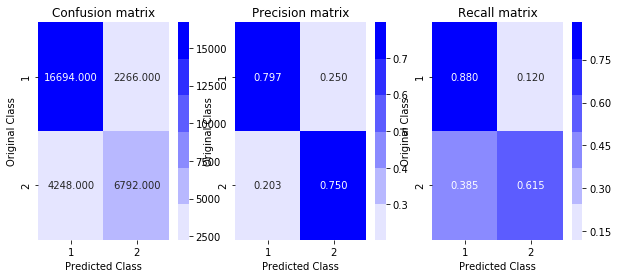

In [32]:
optimal_alpha = np.argmin(log_error)
clf = SGDClassifier(alpha=a_hype[optimal_alpha], penalty='l1', loss='hinge', random_state=100)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

y_pred_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', a_hype[optimal_alpha], "The train data log loss is:",log_loss(y_train, y_pred_train,eps=1e-15))
y_pred_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', a_hype[optimal_alpha], ",The test data log loss is:",log_loss(y_test, y_pred_test,eps=1e-15))
predicted_y =np.argmax(y_pred_test,axis=1) #predict_proba gives P(class1)and p(class2); so we take class1 
#if P(class1)>P(class2) and class2 if P(class1)<P(class2).
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y) #for test data

$observations...$

1. SVM with l2 regularization gives a Train log-loss of 0.437 while l1 regularization gives a Test log-loss of 0.443.<br>
2. Both SVM and Logistic regression gives similar log-loss for train and test data.So probably there is no overfitting.
3. For Logistic Regression , train log-loss is 0.410 and test log-loss is 0.417
4. For both Logistic Reg and SVM(more complex model than LR), the training error(loss) is significantly lower and is comparable to unseen data(cv and test).So probably there is no underfitting(or very less if there is).
5. However we see than the Precision and recall  negative class for both Logistic Regression and SVM  is low.Recall for negative class is low meaning the number of False positive is higher which is a big problem considering the business constraints.Because a lot of the non-similar questions will be classified as similar question by the model.The readers will not be happy as Two non similar questions will have same answers which is as classified by the model.


<h3> 7.5. Bagging</h3>

<h4> 7.5.1. Random Forest</h4>

In [19]:
from sklearn.ensemble import RandomForestClassifier as RFC

estimators =  100 Train Log Loss  0.37907274056325163 cv Log Loss  0.42647513408814786
estimators =  200 Train Log Loss  0.38169702873801237 cv Log Loss  0.4276864028082166
estimators =  250 Train Log Loss  0.38162746282563276 cv Log Loss  0.42867492370382804
estimators =  300 Train Log Loss  0.38161373656433967 cv Log Loss  0.42879355150684334
estimators =  350 Train Log Loss  0.3806467277647112 cv Log Loss  0.42734960722535487
estimators =  450 Train Log Loss  0.3824389996021299 cv Log Loss  0.42907030183317146
estimators =  500 Train Log Loss  0.38137644322390696 cv Log Loss  0.42795202355230505
estimators =  600 Train Log Loss  0.3816720398462949 cv Log Loss  0.4286783138486805
estimators =  800 Train Log Loss  0.38206222285936414 cv Log Loss  0.42846598340663133


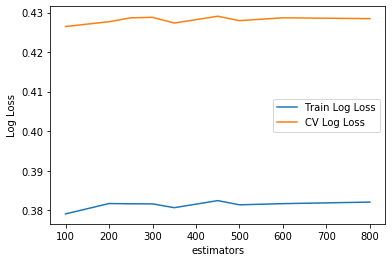

In [20]:
cv_scores = []
train_scores = []

est = [100,200,250,300,350,450,500,600,800]
for item in est:
    clf = RFC(n_estimators = item , max_depth = 10 , n_jobs = -1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, y_pred, eps=1e-15)
    train_scores.append(log_loss_train)
    y_pred_cv = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, y_pred_cv, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('estimators = ',item,'Train Log Loss ',log_loss_train,'cv Log Loss ',log_loss_cv)

plt.plot(est,train_scores,label='Train Log Loss')
plt.plot(est,cv_scores,label='CV Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [21]:
optimal_est_index = np.argmin(cv_scores)
optimal_estimator = est[optimal_est_index]
print(optimal_estimator)

100


<h4>7.5.2. optimizing hyperparameter: depth</h4>

Depth =  5 Train Log Loss  0.4859959812995973 Test Log Loss  0.4876269954234584
Depth =  10 Train Log Loss  0.3841741441193208 Test Log Loss  0.4247919299025994
Depth =  12 Train Log Loss  0.33613600447348574 Test Log Loss  0.41197442221296987
Depth =  15 Train Log Loss  0.26186889880572006 Test Log Loss  0.401394052481266
Depth =  20 Train Log Loss  0.16956181832856468 Test Log Loss  0.39619995734554125
Depth =  25 Train Log Loss  0.1325214876641173 Test Log Loss  0.39684753511153253
Depth =  50 Train Log Loss  0.1181302701942706 Test Log Loss  0.39816227660644565


Text(0, 0.5, 'Log Loss')

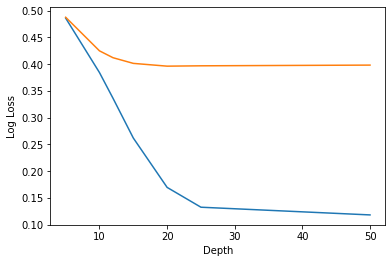

In [19]:
Depth = [5,10,12,15,20,25,50]
cv_scores = []
train_scores = []
for i in Depth:
    clf = RFC(n_estimators=optimal_estimator ,max_depth = i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, predict_y, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('Depth = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_cv)
plt.plot(Depth,train_scores,label='Train Log Loss')
plt.plot(Depth,cv_scores,label='Test Log Loss')
plt.xlabel('Depth') 
plt.ylabel('Log Loss')

In [20]:
optimal_depth_index = np.argmin(cv_scores)
optimal_depth = Depth[optimal_depth_index]
print(optimal_depth)

20


$Observing...$

--> The cv loss decreases as we increase the Max_depth; However the model overfit way too much as the max_depth increases.<br>
--> We have taken 12 as the max_depth as we know Random forest takes overfitted trees(high variance and low bias) with more depths so a max_depth of 5 wont be reasonable.

<h4>7.5.3. Evaluating model(Random Forest Classifier) on test data</h4>

The train log loss is: 0.33930199555782287
The test log loss is: 0.41791195552677524


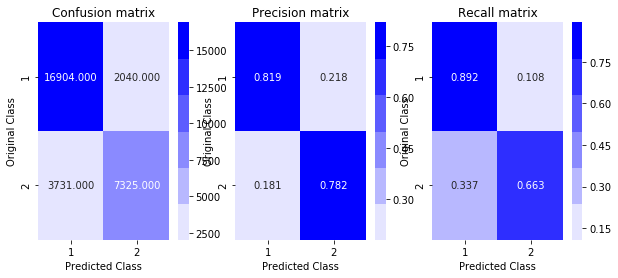

In [22]:
clf = RFC(max_depth = 12,n_estimators = 100,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y_train = clf.predict_proba(X_train)
predict_y = clf.predict_proba(X_test)
print("The train log loss is:",log_loss(y_train, predict_y_train, eps=1e-15))
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

$observations...$

1. The Random Forest gives a train log-loss = 0.339 and a test log-loss of 0.417

2. However at the time of optimizing the hyper-parameters we see that, as we increase the maximum depth of trees in random forest(which is what we do in random forest) over 10-12 , the train log-loss decreases by a large amount.But we see a huge difference between training and test(cross-validation) accuracy in such case which denotes overfitting

<h2> 7.6 XGBoost </h2>

<h3> 7.6.1 XG_Boost with hyperparameter tuning using RandomizedSearchCV </h3>

In [15]:
params = {"n_estimators" : randint(160,210),
              "max_depth" : randint(2,5),
              "min_child_weight": randint(2, 8),
              "learning_rate":uniform(0,0.1),
              "gamma": uniform(0,4),
              "subsample":uniform(0.7,0.3),
              "colsample_bytree": uniform(0.7,0.3),
              "reg_alpha":uniform(50,100)
         }

clf = xgb.XGBClassifier(random_state = 100)

rand_search1 = RandomizedSearchCV(clf, param_distributions = params,return_train_score=True,\
                                   n_iter = 5,cv = 10,scoring = 'f1',random_state = 100,n_jobs = -1)

rand_search1.fit(X_train,y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=100, reg_alph...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000009FDF00F898>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv

In [17]:
print('mean test scores',rand_search1.cv_results_['mean_test_score'])
print('mean train scores',rand_search1.cv_results_['mean_train_score'])

mean test scores [0.71177278 0.72417918 0.69610883 0.72893362 0.73690091]
mean train scores [0.71491021 0.72971965 0.69721699 0.73421012 0.74534445]


<h4> 7.6.1.1 Best estimator: XGBClassifier </h4>

In [19]:
#https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch/
print(rand_search1.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7426196128470933,
              gamma=2.325555849040847, learning_rate=0.047918993684503836,
              max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
              n_estimators=190, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=100,
              reg_alpha=88.194344494311, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7109428169777706,
              verbosity=1)


<h4> 7.6.1.2 Testing the model using test data </h4>

The train log loss is: 0.3649539569648534 The test log loss is: 0.3721426426439701


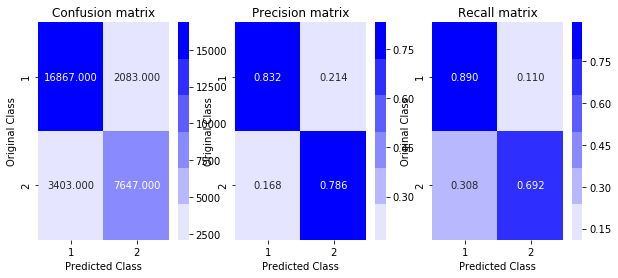

In [30]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7426196128470933,
              gamma=2.325555849040847, learning_rate=0.047918993684503836,
              max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
              n_estimators=190, n_jobs = -1, nthread=None,
              objective='binary:logistic', random_state=100,
              reg_alpha=88.194344494311, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7109428169777706,
              verbosity=1)


clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
predict_y_train = clf.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y_train, eps=1e-15),"The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

$Observations...$

1. XGB Classifier(using RandomSearchCV) gives similar accuracy on test data like others models(Logistic regression , SVM)
2. The test data accuracy is almost similar to the train data accuracy.Hence no overfitting expected.
3. Similar to other model , XGB Classifier gives low precision and recall value for negative class.recall value is even lower.

<h3> 7.6.2 XG_Boost with hyperparameter tuning using normal log-loss scores of test data </h3>

estimators =  150 Train Log Loss  0.3384315505383993 Test Log Loss  0.347507816597125
estimators =  200 Train Log Loss  0.32655500596355763 Test Log Loss  0.34154159226911796
estimators =  350 Train Log Loss  0.3026362476892266 Test Log Loss  0.3336160163740998
estimators =  500 Train Log Loss  0.2837449154536923 Test Log Loss  0.32990475459352514
estimators =  700 Train Log Loss  0.26278340881749057 Test Log Loss  0.3267027492495286
estimators =  850 Train Log Loss  0.2493556599013961 Test Log Loss  0.3256794658819254
850


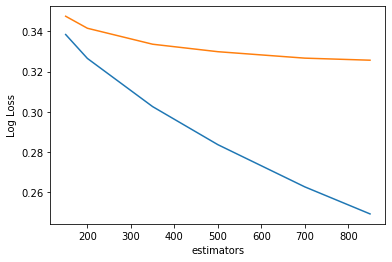

In [11]:
estimators = [150,200,350,500,700,850]
cv_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, predict_y, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_cv)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,cv_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

optimal_estimator_index = np.argmin(cv_scores)
optimal_estimator = estimators[optimal_estimator_index]
print(optimal_estimator)

  0%|                                                    | 0/6 [00:00<?, ?it/s]

estimators =  0.01 Train Log Loss  0.42946131941645727 Test Log Loss  0.42920550070206326


 17%|███████▏                                   | 1/6 [03:55<19:36, 235.34s/it]

estimators =  0.03 Train Log Loss  0.37254593233178296 Test Log Loss  0.37385423479276886


 33%|██████████████▎                            | 2/6 [08:18<16:14, 243.61s/it]

estimators =  0.05 Train Log Loss  0.35437167527964364 Test Log Loss  0.3594196698356924


 50%|█████████████████████▌                     | 3/6 [12:48<12:35, 251.72s/it]

estimators =  0.1 Train Log Loss  0.32632406252994606 Test Log Loss  0.3428955733143992


 67%|████████████████████████████▋              | 4/6 [17:19<08:35, 257.51s/it]

estimators =  0.15 Train Log Loss  0.30964696716926254 Test Log Loss  0.3367708696688734


 83%|███████████████████████████████████▊       | 5/6 [21:55<04:23, 263.08s/it]

estimators =  0.2 Train Log Loss  0.2970480202106 Test Log Loss  0.3343321056642889


100%|███████████████████████████████████████████| 6/6 [26:29<00:00, 264.94s/it]


0.2


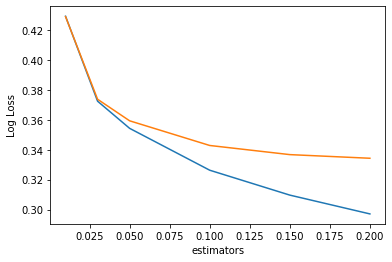

In [11]:
learn_rates = [0.01,0.03,0.05,0.1,0.15,0.2]

cv_scores = []
train_scores = []
for i in tqdm(learn_rates):
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=200,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, predict_y, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_cv)
plt.plot(learn_rates,train_scores,label='Train Log Loss')
plt.plot(learn_rates,cv_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

optimal_learning_index = np.argmin(cv_scores)
optimal_learn_rate = learn_rates[optimal_learning_index]
print(optimal_learn_rate)

  0%|                                                    | 0/5 [00:00<?, ?it/s]

estimators =  3 Train Log Loss  0.35437167527964364 Test Log Loss  0.3594196698356924


 20%|████████▌                                  | 1/5 [03:38<14:33, 218.33s/it]

estimators =  5 Train Log Loss  0.3057748266623857 Test Log Loss  0.3386359593958727


 40%|█████████████████▏                         | 2/5 [10:03<13:24, 268.27s/it]

estimators =  7 Train Log Loss  0.2316521785901328 Test Log Loss  0.3284637763962604


 60%|█████████████████████████▊                 | 3/5 [19:17<11:48, 354.25s/it]

estimators =  9 Train Log Loss  0.13898725838448772 Test Log Loss  0.32493453338076334


 80%|██████████████████████████████████▍        | 4/5 [31:15<07:43, 463.18s/it]

estimators =  11 Train Log Loss  0.06313610567758855 Test Log Loss  0.3266190149907118


100%|███████████████████████████████████████████| 5/5 [45:48<00:00, 549.64s/it]


9


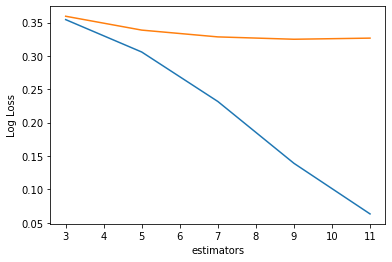

In [12]:
depths = [3,5,7,9,11]

cv_scores = []
train_scores = []
for i in tqdm(depths):
    clf = xgb.XGBClassifier(max_depth=i,learning_rate=0.05,n_estimators=200,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, predict_y, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_cv)
plt.plot(depths,train_scores,label='Train Log Loss')
plt.plot(depths,cv_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

optimal_depth_index = np.argmin(cv_scores)
optimal_depth = depths[optimal_depth_index]
print(optimal_depth)

  0%|                                                    | 0/7 [00:00<?, ?it/s]

estimators =  0.5 Train Log Loss  0.35703485016094766 Test Log Loss  0.3638304403157755


 14%|██████▏                                    | 1/7 [03:51<23:10, 231.71s/it]

estimators =  1 Train Log Loss  0.3574183047104577 Test Log Loss  0.36430042888347747


 29%|████████████▎                              | 2/7 [08:18<20:11, 242.25s/it]

estimators =  5 Train Log Loss  0.3582712015331633 Test Log Loss  0.36460406864150097


 43%|██████████████████▍                        | 3/7 [12:48<16:42, 250.64s/it]

estimators =  15 Train Log Loss  0.3604588582326482 Test Log Loss  0.36656363921003815


 57%|████████████████████████▌                  | 4/7 [17:18<12:49, 256.39s/it]

estimators =  75 Train Log Loss  0.3691105334815636 Test Log Loss  0.3732953244347591


 71%|██████████████████████████████▋            | 5/7 [21:57<08:46, 263.18s/it]

estimators =  150 Train Log Loss  0.3783117803858061 Test Log Loss  0.38108300231377196


 86%|████████████████████████████████████▊      | 6/7 [26:32<04:26, 266.71s/it]

estimators =  200 Train Log Loss  0.3841265620208745 Test Log Loss  0.38631433250418024


100%|███████████████████████████████████████████| 7/7 [31:06<00:00, 266.67s/it]


0.5


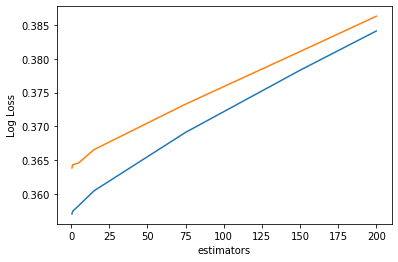

In [11]:
alpha = [0.5,1,5,15,75,150,200]

cv_scores = []
train_scores = []
for i in tqdm(alpha):
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.05,reg_alpha=i,n_estimators=200,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_cv)
    log_loss_cv = log_loss(y_cv, predict_y, eps=1e-15)
    cv_scores.append(log_loss_cv)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_cv)
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,cv_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')

optimal_reg_alpha = np.argmin(cv_scores)
optimal_alpha = alpha[optimal_reg_alpha]
print(optimal_alpha)

The train log loss is: 0.36515384004823387 The test log loss is: 0.3711217706534313


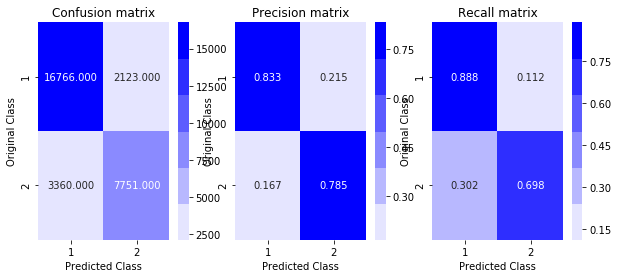

In [13]:
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.05,n_estimators=200,reg_alpha=50,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
predict_y_train = clf.predict_proba(X_train)
print("The train log loss is:",log_loss(y_train, predict_y_train, eps=1e-15),"The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2 style = "color: blue"> 8. Tfidf encoding of features</h1>


<h3> 8.1. Preparing the data</h2>


In [4]:
#we take all the features excluding the tfidf weighted w2v.
df = pd.read_csv("DATA/new_features_vectors.csv")
df = df.iloc[:,0:27]
print(df.columns)
df = df.fillna(' ')

Index(['is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words',
       'q2_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+freq_q2', 'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')


In [5]:
#we need the text data to convert into ifidf vectors
df1 = pd.read_csv("DATA/train.csv")
df['Text'] = df1.question1 + df1.question2
df.columns

Index(['is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_words',
       'q2_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+freq_q2', 'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min',
       'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'Text'],
      dtype='object')

In [6]:
y_tf = df['is_duplicate'].values
X_tf = df.drop('is_duplicate',axis = 1)

<h3> 8.1.1 Train , Test and cv dataset by splitting the data(48:30:12)</h4>


In [7]:
X_train_tfidf,X_test_tf, y_train_tfidf, y_test_tf = train_test_split(X_tf , y_tf, stratify=y_tf, test_size=0.3,random_state=100)
X_train_tf,X_cv_tf, y_train_tf, y_cv_tf = train_test_split(X_train_tfidf , y_train_tfidf, stratify=y_train_tfidf, test_size=0.3,random_state=100)

In [8]:
print(X_train_tf.shape,y_train_tf.shape)
print(X_test_tf.shape,y_test_tf.shape)
print(X_cv_tf.shape,y_cv_tf.shape)

(198102, 27) (198102,)
(121287, 27) (121287,)
(84901, 27) (84901,)


<h3> 8.2 TfIdf encoding of Text feature </h2>

In [9]:
tfidf = TfidfVectorizer(ngram_range=(1,3),max_features=200000)
train_tfidf = tfidf.fit_transform(X_train_tf["Text"].astype('U'))
test_tfidf = tfidf.transform(X_test_tf["Text"].astype('U'))
cv_tfidf = tfidf.transform(X_cv_tf["Text"].astype('U'))
print('No of Tfidf features',len(tfidf.get_feature_names()))

No of Tfidf features 200000


In [10]:
X_train_tf = X_train_tf.drop('Text',axis=1)
X_test_tf = X_test_tf.drop('Text',axis=1)
X_cv_tf = X_cv_tf.drop('Text',axis=1)

<h3> 8.2.1 Unscaled Data</h4>


In [11]:
from scipy.sparse import hstack
X_train_final = hstack((X_train_tf.values,train_tfidf))
X_test_final = hstack((X_test_tf.values,test_tfidf))
X_cv_final = hstack((X_cv_tf.values,cv_tfidf))

In [12]:
print(X_train_final.shape,y_train_tf.shape)
print(X_test_final.shape,y_test_tf.shape)
print(X_cv_final.shape,y_cv_tf.shape)

(198102, 200026) (198102,)
(121287, 200026) (121287,)
(84901, 200026) (84901,)


<h3> 8.2.2 Scaled Data</h4>


In [13]:
scale = StandardScaler(with_mean=False)
X_train_scale = scale.fit_transform(X_train_final)
X_test_scale = scale.transform(X_test_final)
X_cv_scale = scale.transform(X_cv_final)

In [14]:
print(X_train_scale.shape,y_train_tf.shape)
print(X_test_scale.shape,y_test_tf.shape)
print(X_cv_scale.shape,y_cv_tf.shape)

(198102, 200026) (198102,)
(121287, 200026) (121287,)
(84901, 200026) (84901,)


<h2 style = "color:blue"> 8.3 Applying Logistic Regression on tfidf encoded features</h2>
<h3> 8.3.1 Logistic regression using scaled data</h3>

<h4> 8.3.1.1 Training the model using train data and optimizing it using cross-validation data</h4>


  0%|                                                    | 0/7 [00:00<?, ?it/s]

For values of alpha =  1e-05 The train log loss is: 0.2957432527272229 The cv log loss is: 0.4481130108276918


 14%|██████▎                                     | 1/7 [00:40<04:01, 40.28s/it]

For values of alpha =  0.0001 The train log loss is: 0.2961410907181772 The cv log loss is: 0.44795206477401567


 29%|████████████▌                               | 2/7 [01:02<02:54, 34.97s/it]

For values of alpha =  0.001 The train log loss is: 0.29438392136728814 The cv log loss is: 0.4476770824436613


 43%|██████████████████▊                         | 3/7 [01:17<01:55, 28.87s/it]

For values of alpha =  0.01 The train log loss is: 0.26757153695514024 The cv log loss is: 0.4344916898749662


 57%|█████████████████████████▏                  | 4/7 [01:24<01:06, 22.25s/it]

For values of alpha =  0.1 The train log loss is: 0.23383575713227128 The cv log loss is: 0.40685882753772823


 71%|███████████████████████████████▍            | 5/7 [01:29<00:34, 17.07s/it]

For values of alpha =  1 The train log loss is: 0.2786371616328489 The cv log loss is: 0.40655421382792445


 86%|█████████████████████████████████████▋      | 6/7 [01:34<00:13, 13.45s/it]

For values of alpha =  10 The train log loss is: 0.38105923574924455 The cv log loss is: 0.45455655873896056


100%|████████████████████████████████████████████| 7/7 [01:38<00:00, 14.09s/it]


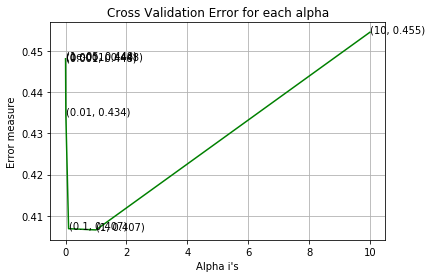

In [33]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
#SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error_array=[]
for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_scale, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_scale, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_scale)
    predict_y_train = sig_clf.predict_proba(X_train_scale)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The train log loss is:",log_loss(y_train_tf, predict_y_train, labels=clf.classes_,eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h4> 8.3.1.2 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  1 The train log loss is: 0.2786371616328489
For values of best alpha =  1 The test log loss is: 0.40667855228093874
Total number of data points : 121287


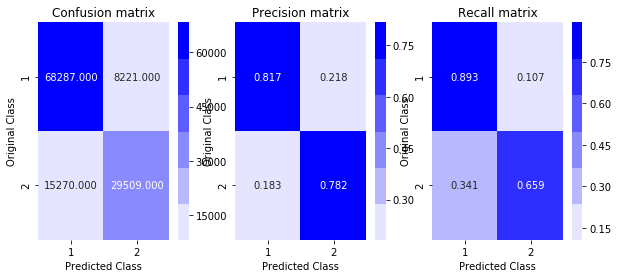

In [34]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=1, average=False,class_weight=None,early_stopping=False,epsilon=0.1, eta0=0.0,\
                                        fit_intercept=True,l1_ratio=0.15,learning_rate='optimal',loss='log', max_iter=1000,\
                                        n_iter_no_change=5,n_jobs=None, penalty='l2',power_t=0.5,random_state=42,\
                                        shuffle=True, tol=0.001,validation_fraction=0.1,verbose=0,warm_start=False)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_scale, y_train_tf)

predict_y_train = sig_clf.predict_proba(X_train_scale)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y_train,eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_scale)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y_test,eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test_tf, predicted_y_test)

<h4> 8.3.1.3 LR using randomization in choosing the hyperparameters to optimize</h4>


  0%|                                                   | 0/14 [00:00<?, ?it/s]

For values of alpha =  0.0504 The train log loss is: 0.2382259424433176 The cv log loss is: 0.4141158857034821


  7%|███                                        | 1/14 [00:05<01:06,  5.10s/it]

For values of alpha =  0.0685 The train log loss is: 0.23602955653669 The cv log loss is: 0.41113257624548655


 14%|██████▏                                    | 2/14 [00:10<01:00,  5.07s/it]

For values of alpha =  0.0689 The train log loss is: 0.2359823541496325 The cv log loss is: 0.4110617718133849


 21%|█████████▏                                 | 3/14 [00:14<00:54,  4.97s/it]

For values of alpha =  0.0823 The train log loss is: 0.23461846927530206 The cv log loss is: 0.4089966685405443


 29%|████████████▎                              | 4/14 [00:19<00:49,  4.93s/it]

For values of alpha =  0.1121 The train log loss is: 0.23376355956257977 The cv log loss is: 0.4057912351961512


 36%|███████████████▎                           | 5/14 [00:24<00:44,  4.94s/it]

For values of alpha =  0.2037 The train log loss is: 0.23704468670603937 The cv log loss is: 0.40138892315263314


 43%|██████████████████▍                        | 6/14 [00:30<00:40,  5.10s/it]

For values of alpha =  0.2247 The train log loss is: 0.2382398369570141 The cv log loss is: 0.4009934211795652


 50%|█████████████████████▌                     | 7/14 [00:35<00:36,  5.17s/it]

For values of alpha =  0.2353 The train log loss is: 0.2388654280957089 The cv log loss is: 0.4008362014473121


 57%|████████████████████████▌                  | 8/14 [00:40<00:30,  5.12s/it]

For values of alpha =  0.2667 The train log loss is: 0.24077668161152457 The cv log loss is: 0.40051822243422347


 64%|███████████████████████████▋               | 9/14 [00:45<00:25,  5.19s/it]

For values of alpha =  0.3457 The train log loss is: 0.2456952015861431 The cv log loss is: 0.4002364476719325


 71%|██████████████████████████████            | 10/14 [00:50<00:20,  5.12s/it]

For values of alpha =  0.3797 The train log loss is: 0.24779085841494283 The cv log loss is: 0.40032247537881555


 79%|█████████████████████████████████         | 11/14 [00:55<00:15,  5.11s/it]

For values of alpha =  0.4208 The train log loss is: 0.25027916214417395 The cv log loss is: 0.40051834831127253


 86%|████████████████████████████████████      | 12/14 [01:00<00:10,  5.09s/it]

For values of alpha =  0.454 The train log loss is: 0.2522465090237555 The cv log loss is: 0.40073008865503856


 93%|███████████████████████████████████████   | 13/14 [01:05<00:05,  5.06s/it]

For values of alpha =  0.4955 The train log loss is: 0.25464681267980055 The cv log loss is: 0.4010474612070658


100%|██████████████████████████████████████████| 14/14 [01:10<00:00,  5.06s/it]


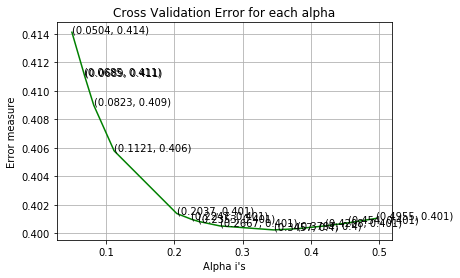

In [35]:
#SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# Generate Random Float numbers in Python using random() and Uniform() functions: 
# https://pynative.com/python-get-random-float-numbers/
alpha = np.random.uniform(0.05,0.5,14)
alpha = np.round(alpha,4)
alpha.sort()
log_error_array=[]

for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_scale, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_scale, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_scale)
    predict_y_train = sig_clf.predict_proba(X_train_scale)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The train log loss is:",log_loss(y_train_tf, predict_y_train, labels=clf.classes_,eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()




<h4> 8.3.1.4 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  0.3457 The train log loss is: 0.2456952015861431
For values of best alpha =  0.3457 The test log loss is: 0.40036815039364654
Total number of data points : 121287


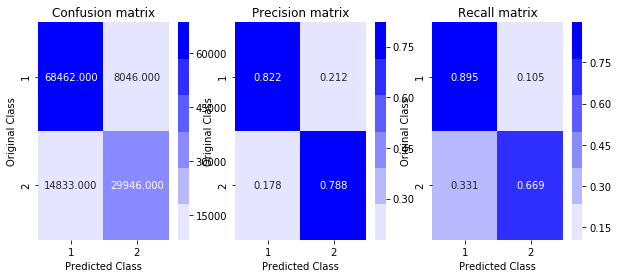

In [36]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_scale, y_train_tf)

predict_y_train = sig_clf.predict_proba(X_train_scale)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y_train,eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_scale)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y_test,eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test_tf, predicted_y_test)

$Observations...$

1. For scaled data, Logistic Regression gives a train log-loss of about 0.24 and a test log-loss of 0.40

2. The difference in accuracy of the two signifies overfitting.

3. We are hence fitting the models to unscaled data, to see if it can remove the ooverfitting.

<h3> 8.3.2 Logistic Regression using unscaled data</h3>


<h4> 8.3.2.1 Training the model using train data and optimizing it using cross-validation data</h4>


For values of alpha =  1e-05 The trin log loss is: 0.389828303335589 The cv log loss is: 0.3948501722847176
For values of alpha =  0.0001 The trin log loss is: 0.3917599257945187 The cv log loss is: 0.3956549957342563
For values of alpha =  0.001 The trin log loss is: 0.4336020212667494 The cv log loss is: 0.4352719168350103
For values of alpha =  0.01 The trin log loss is: 0.4563971934822286 The cv log loss is: 0.4570266528740626
For values of alpha =  0.1 The trin log loss is: 0.49031848523680194 The cv log loss is: 0.4915815159249797
For values of alpha =  1 The trin log loss is: 0.5196951401026453 The cv log loss is: 0.5206337984210221
For values of alpha =  10 The trin log loss is: 0.5528519512394626 The cv log loss is: 0.5527166126892357


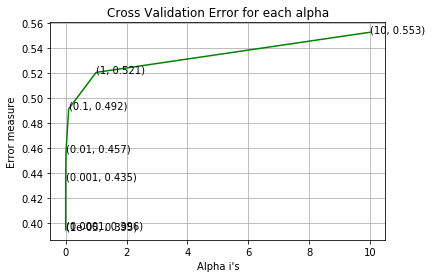

In [37]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
#SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_final, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_final)
    predict_y_train = sig_clf.predict_proba(X_train_final)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i,  "The trin log loss is:",log_loss(y_train_tf, predict_y_train,labels=clf.classes_, eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()



In [38]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train_tf)


CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False,
                                                    class_weight=None,
                                                    early_stopping=False,
                                                    epsilon=0.1, eta0=0.0,
                                                    fit_intercept=True,
                                                    l1_ratio=0.15,
                                                    learning_rate='optimal',
                                                    loss='log', max_iter=1000,
                                                    n_iter_no_change=5,
                                                    n_jobs=None, penalty='l2',
                                                    power_t=0.5,
                                                    random_state=42,
                                                    shuffle=True, tol=0.001,
                                           

<h4> 8.3.2.2 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  1e-05 The train log loss is: 0.389828303335589
For values of best alpha =  1e-05 The test log loss is: 0.3970221326397303
Total number of data points : 121287


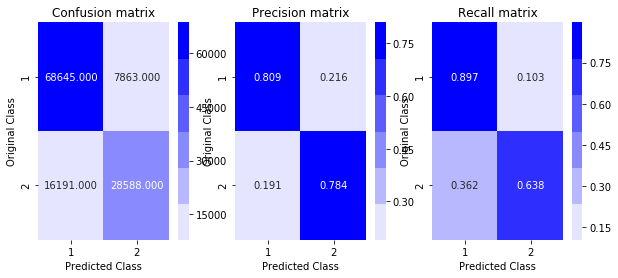

In [39]:
predict_y_train = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y_train,eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y_test,eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test_tf, predicted_y_test)

$Observations...$

1. For scaled data, logistic regression gives train log-loss = 0.245 and test log-loss = 0.400
2. We see clear overfitting in case of logistic regression applied to scaled data
3. In case of unscaled data, logistic regression gives train log-loss = 0.389  and test log-loss = 0.397
4. Overfitting is removed by using unscaled data.
5. Now we involve one level of randomization, and test the model below.

<h4> 8.3.2.3 Using randomization in choosing the hyperparameters to optimize </h4>


For values of alpha =  3.3e-06 The train log loss is: 0.3869563106432643 The cv log loss is: 0.3922570406647552
For values of alpha =  8.24e-06 The train log loss is: 0.3881177961118619 The cv log loss is: 0.39373268738647604
For values of alpha =  8.25e-06 The train log loss is: 0.39368846637459803 The cv log loss is: 0.39918242921108305
For values of alpha =  1.073e-05 The train log loss is: 0.3908236556788132 The cv log loss is: 0.39652490684527
For values of alpha =  1.373e-05 The train log loss is: 0.39457764778509125 The cv log loss is: 0.39997136809290923
For values of alpha =  1.608e-05 The train log loss is: 0.3925238636248262 The cv log loss is: 0.39819952999300573
For values of alpha =  1.788e-05 The train log loss is: 0.40101584660170714 The cv log loss is: 0.40550227248431325
For values of alpha =  2.551e-05 The train log loss is: 0.38722728104761633 The cv log loss is: 0.39239739139552254
For values of alpha =  2.576e-05 The train log loss is: 0.388466647029409 The cv log

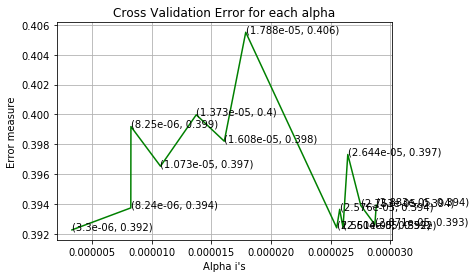

In [40]:
# SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# Generate Random Float numbers in Python using random() and Uniform() functions: 
# https://pynative.com/python-get-random-float-numbers/
alpha = np.random.uniform(0.000002,0.00003,14)
alpha = np.round(alpha,8)
alpha.sort()
log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_final, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf,cv = 5, method="sigmoid")
    sig_clf.fit(X_train_final, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_final)
    predict_y_train = sig_clf.predict_proba(X_train_final)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i,  "The train log loss is:",log_loss(y_train_tf, predict_y_train,labels=clf.classes_, eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h4> 8.3.2.4 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  3.3e-06 The train log loss is: 0.3869563106432643
For values of best alpha =  3.3e-06 The test log loss is: 0.39365187247881256
Total number of data points : 121287


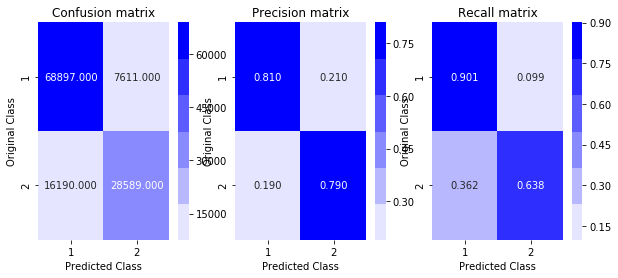

In [41]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf,cv = 5, method="sigmoid")
sig_clf.fit(X_train_final, y_train_tf)


predict_y_train = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y_train,eps=1e-15))
predict_y_test = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y_test,eps=1e-15))
predicted_y_test =np.argmax(predict_y_test,axis=1)
print("Total number of data points :", len(predicted_y_test))
plot_confusion_matrix(y_test_tf, predicted_y_test)

$Observations...$

1. With scaling , the models seems to overfit as there is a significant difference between Train log-loss and test log-loss<br>
2. With Unscaled data(with randomization) , model performance: Train Log-Loss = 0.387 , Test log loss = 0.394
3. For unscaled data, models show better performance( metric = log-loss) overall (on test data) and also overfitting is signicantly reduced
4. So we take unscaled data for SVM also.

<h2> 8.4 Applying SVM on tfidf encoded features</h2>
<h4> 8.4.1 Using Unscaled data and l2 regulization</h4>


For values of alpha =  1e-05 The train log loss is: 0.39036320430018673 The cv log loss is: 0.39601538074707476
For values of alpha =  0.0001 The train log loss is: 0.39998967898453225 The cv log loss is: 0.40414533441932615
For values of alpha =  0.001 The train log loss is: 0.43220937269482895 The cv log loss is: 0.4344131945405977
For values of alpha =  0.01 The train log loss is: 0.4588581415353313 The cv log loss is: 0.4599087622677635
For values of alpha =  0.1 The train log loss is: 0.490902632464826 The cv log loss is: 0.4925084801772075
For values of alpha =  1 The train log loss is: 0.518157647104919 The cv log loss is: 0.5201279466690703
For values of alpha =  10 The train log loss is: 0.5534794082463902 The cv log loss is: 0.5538878680789268


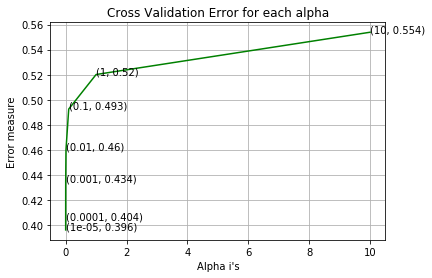

In [18]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
#SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs = -1)
    clf.fit(X_train_final, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf,cv =5, method="sigmoid")
    sig_clf.fit(X_train_final, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_final)
    predict_y_train = sig_clf.predict_proba(X_train_final)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The train log loss is:",log_loss(y_train_tf, predict_y_train, labels=clf.classes_,eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h4> 8.4.2 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  1e-05 The train log loss is: 0.3941764213496691
For values of best alpha =  1e-05 The test log loss is: 0.40051984613745106
Total number of data points : 121287


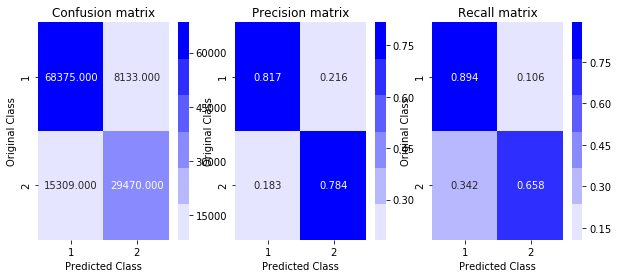

In [19]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train_tf)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tf, predicted_y)

<h4> 8.4.3 Selecting random hyperparameters for optimization </h4>


  0%|                                                   | 0/14 [00:00<?, ?it/s]

For values of alpha =  3.85e-06 The train log loss is: 0.3997688152527564 The cv log loss is: 0.40522454801479973


  7%|███                                       | 1/14 [02:03<26:49, 123.79s/it]

For values of alpha =  4.2e-06 The train log loss is: 0.40123812523099484 The cv log loss is: 0.40566819601929816


 14%|██████                                    | 2/14 [03:57<24:08, 120.67s/it]

For values of alpha =  5.3e-06 The train log loss is: 0.38697492669725275 The cv log loss is: 0.39186427685656366


 21%|█████████                                 | 3/14 [06:09<22:44, 124.04s/it]

For values of alpha =  5.75e-06 The train log loss is: 0.3889442374917556 The cv log loss is: 0.394276330625093


 29%|████████████                              | 4/14 [08:12<20:37, 123.75s/it]

For values of alpha =  5.96e-06 The train log loss is: 0.3896616163109866 The cv log loss is: 0.394437877643184


 36%|███████████████                           | 5/14 [10:17<18:38, 124.25s/it]

For values of alpha =  1.139e-05 The train log loss is: 0.40449010327245827 The cv log loss is: 0.40816298138196794


 43%|██████████████████                        | 6/14 [12:16<16:22, 122.78s/it]

For values of alpha =  1.169e-05 The train log loss is: 0.399851220731261 The cv log loss is: 0.40500679532905515


 50%|█████████████████████                     | 7/14 [14:06<13:50, 118.67s/it]

For values of alpha =  1.213e-05 The train log loss is: 0.39777173624464074 The cv log loss is: 0.4027600655262355


 57%|████████████████████████                  | 8/14 [16:15<12:11, 121.93s/it]

For values of alpha =  1.372e-05 The train log loss is: 0.3933924637204682 The cv log loss is: 0.39825623214649813


 64%|███████████████████████████               | 9/14 [18:25<10:22, 124.41s/it]

For values of alpha =  1.558e-05 The train log loss is: 0.3917356239098318 The cv log loss is: 0.3966678606234426


 71%|█████████████████████████████▎           | 10/14 [20:34<08:22, 125.66s/it]

For values of alpha =  2.131e-05 The train log loss is: 0.39180932105312116 The cv log loss is: 0.3965592700229428


 79%|████████████████████████████████▏        | 11/14 [22:40<06:17, 125.67s/it]

For values of alpha =  2.319e-05 The train log loss is: 0.4151451898064771 The cv log loss is: 0.4183044205529673


 86%|███████████████████████████████████▏     | 12/14 [24:36<04:05, 122.88s/it]

For values of alpha =  2.399e-05 The train log loss is: 0.3935134303408426 The cv log loss is: 0.3985444317137772


 93%|██████████████████████████████████████   | 13/14 [26:39<02:03, 123.06s/it]

For values of alpha =  2.565e-05 The train log loss is: 0.3918945500138438 The cv log loss is: 0.39606226961571467


100%|█████████████████████████████████████████| 14/14 [28:33<00:00, 122.41s/it]


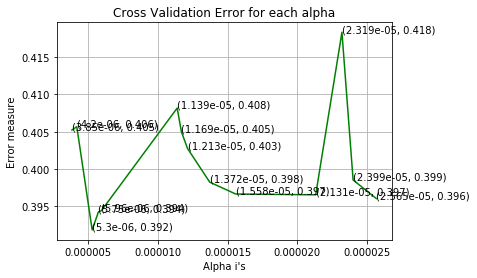

In [20]:
#https://pynative.com/python-get-random-float-numbers/
alpha = np.random.uniform(0.000002,0.00003,14)
alpha = np.round(alpha,8)
alpha.sort()
log_error_array=[]

for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42, n_jobs = -1)
    clf.fit(X_train_final, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_final)
    predict_y_train = sig_clf.predict_proba(X_train_final)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The train log loss is:",log_loss(y_train_tf, predict_y_train, labels=clf.classes_,eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h4> 8.4.4 Testing the model using optimal hyperparameter on test data</h4>


For values of best alpha =  5.3e-06 The train log loss is: 0.38697492669725275
For values of best alpha =  5.3e-06 The test log loss is: 0.3934896851727093
Total number of data points : 121287


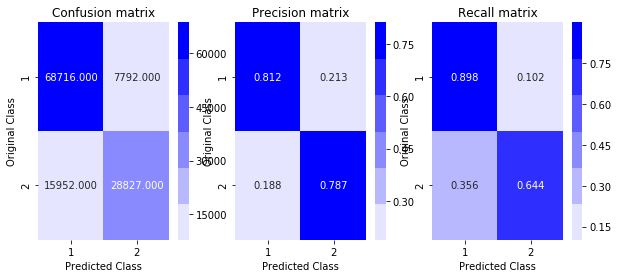

In [21]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train_tf)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tf, predicted_y)

$ Observations...$

1. Using tfidf encoded features,For SVM(l1 regulization), the train log-loss is about 0.386 and test log-loss is 0.393 which is almost similar to the accuracy given by logistic regression.
2. SVM is  a more complex model than Logistic Regression.So, giving similar accuracy signifies that there is very less or no underfitting.
3. However, in all the models we see that although the log-loss is significantly lower than that given by a random model,but the precision and recall for negative class(non similar question) is low.Low recall(like 0.644) for negative class can be really harmful considering the business constraints of this problem.Low recall for negative class implies that the number of False positives are high.So two non similar questions will be categorized as similar by the models and so will have same answers which will hamper the reader's experience.

<h4> 8.4.5 SVM using Unscaled data and l1 regulization</h4>

  0%|                                                   | 0/14 [00:00<?, ?it/s]

For values of alpha =  2.66e-06 The train log loss is: 0.40730990189765354 The cv log loss is: 0.41607279561958965


  7%|███                                       | 1/14 [04:04<52:59, 244.59s/it]

For values of alpha =  5.32e-06 The train log loss is: 0.42166311731584005 The cv log loss is: 0.4293406572273132


 14%|██████                                    | 2/14 [08:17<49:26, 247.19s/it]

For values of alpha =  7.72e-06 The train log loss is: 0.4215157813811088 The cv log loss is: 0.42833597841209864


 21%|█████████                                 | 3/14 [13:13<47:58, 261.69s/it]

For values of alpha =  8.57e-06 The train log loss is: 0.41766346497828766 The cv log loss is: 0.42408197823473104


 29%|████████████                              | 4/14 [17:38<43:46, 262.67s/it]

For values of alpha =  1.012e-05 The train log loss is: 0.42457911219123956 The cv log loss is: 0.4311327790903291


 36%|███████████████                           | 5/14 [22:00<39:22, 262.46s/it]

For values of alpha =  1.129e-05 The train log loss is: 0.425094247817282 The cv log loss is: 0.4316111209649759


 43%|██████████████████                        | 6/14 [26:32<35:22, 265.32s/it]

For values of alpha =  1.458e-05 The train log loss is: 0.4292313666494868 The cv log loss is: 0.4354181558606387


 50%|█████████████████████                     | 7/14 [30:50<30:42, 263.23s/it]

For values of alpha =  1.562e-05 The train log loss is: 0.43090799762560933 The cv log loss is: 0.4371646953732937


 57%|████████████████████████                  | 8/14 [38:28<32:09, 321.62s/it]

For values of alpha =  2.426e-05 The train log loss is: 0.43376157933783854 The cv log loss is: 0.43930163483096385


 64%|███████████████████████▊             | 9/14 [2:36:56<3:16:27, 2357.47s/it]

For values of alpha =  2.663e-05 The train log loss is: 0.4364758164497918 The cv log loss is: 0.44198754644792665


 71%|█████████████████████████▋          | 10/14 [2:50:59<2:06:52, 1903.23s/it]

For values of alpha =  2.747e-05 The train log loss is: 0.433756721416695 The cv log loss is: 0.43897709710915866


 79%|████████████████████████████▎       | 11/14 [3:04:34<1:18:49, 1576.58s/it]

For values of alpha =  2.788e-05 The train log loss is: 0.433569149305922 The cv log loss is: 0.4388955410507183


 86%|████████████████████████████████▌     | 12/14 [3:17:07<44:19, 1329.54s/it]

For values of alpha =  2.872e-05 The train log loss is: 0.43630455493696 The cv log loss is: 0.44163643096929056


 93%|███████████████████████████████████▎  | 13/14 [3:28:45<19:00, 1140.20s/it]

For values of alpha =  2.911e-05 The train log loss is: 0.4364648551481245 The cv log loss is: 0.4420765121629986


100%|███████████████████████████████████████| 14/14 [3:42:37<00:00, 954.07s/it]


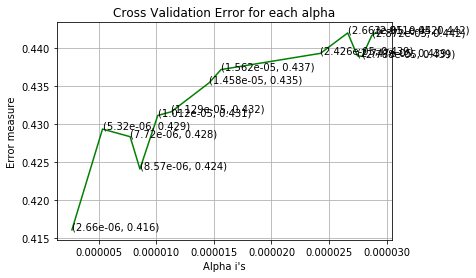

In [33]:
#https://pynative.com/python-get-random-float-numbers/
alpha = np.random.uniform(0.000002,0.00003,14)
alpha = np.round(alpha,8)
alpha.sort()
log_error_array=[]

for i in tqdm(alpha):
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, n_jobs = -1)
    clf.fit(X_train_final, y_train_tf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train_tf)
    predict_y = sig_clf.predict_proba(X_cv_final)
    predict_y_train = sig_clf.predict_proba(X_train_final)
    log_error_array.append(log_loss(y_cv_tf, predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The train log loss is:",log_loss(y_train_tf, predict_y_train, labels=clf.classes_,eps=1e-15),"The cv log loss is:",log_loss(y_cv_tf, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

<h4> 8.4.6 Testing the model using optimal hyperparameter on test data</h4>

For values of best alpha =  2.66e-06 The train log loss is: 0.40730990189765354
For values of best alpha =  2.66e-06 The test log loss is: 0.4159114614444361
Total number of data points : 121287


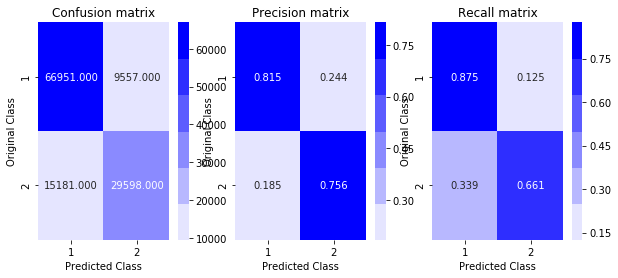

In [35]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,n_jobs = -1)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train_tf)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_tf, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_tf, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tf, predicted_y)

<h2> 8.5 XG_Boost with hyperparameter tuning using RandomizedSearchCV(for tiidf encoded features) </h2>

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as randint
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier as RFC

params = {"n_estimators" : randint(150,200),
              "max_depth" : randint(2,5),
              "min_child_weight": randint(2, 8),
              "learning_rate":uniform(0,0.1),
              "gamma": uniform(0,4),
              "subsample":uniform(0.7,0.3),
              "colsample_bytree": uniform(0.7,0.3),
              "reg_alpha":uniform(50,100)
         }

clf = xgb.XGBClassifier(random_state = 100,n_jobs=-1)
rand_search = RandomizedSearchCV(clf, param_distributions = params,return_train_score=True,\
                                   n_iter = 5,cv = 10,scoring = 'f1',random_state = 100)

rand_search.fit(X_train_final,y_train_tf)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=100, reg_alp...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000CBC29C70F0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv

In [42]:
print(rand_search.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7426196128470933,
              gamma=2.325555849040847, learning_rate=0.047918993684503836,
              max_delta_step=0, max_depth=4, min_child_weight=3, missing=None,
              n_estimators=180, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=100,
              reg_alpha=88.194344494311, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7109428169777706,
              verbosity=1)


<h4> 8.5.1 Testing the model using optimal hyperparameter on test data</h4>


The train log loss is: 0.356533739115174 The test log loss is: 0.35934502659814277


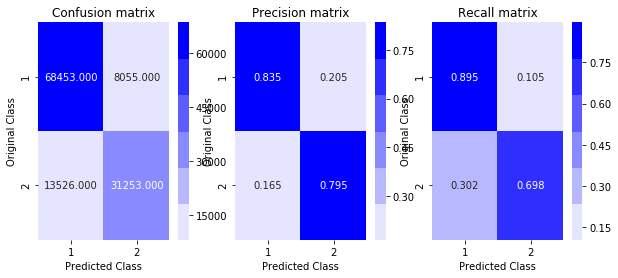

In [43]:
#https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch/
clf = rand_search.best_estimator_

clf.fit(X_train_final,y_train_tf)
predict_y = clf.predict_proba(X_test_final)
predict_y_train = clf.predict_proba(X_train_final)
print("The train log loss is:",log_loss(y_train_tf, predict_y_train, eps=1e-15),"The test log loss is:",log_loss(y_test_tf, predict_y, eps=1e-15))
predicted_y = np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test_tf, predicted_y)

<h2> 9. Observations and Conclusions </h2>


In [46]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Vectorizer(text)", "Hyper Parameter(alpha)", "LOG-LOSS(train)", "LOG-LOSS(test)"]

table.add_row(["LR(l2)", "tfidf_w2v","0.1","0.410","0.417" ])
table.add_row(["SVM(l2)","tfidf weighted w2v", "0.01","0.414","0.420" ])
table.add_row(["SVM(l1)", "tfidf weighted w2v", "1e-05", "0.437","0.443"])
table.add_row(["Bagging", "tfidf weighted w2v", "{ max_depth: 12, estimator: 100}","0.339","0.417" ])
table.add_row(["xgBoost ","tfidf weighted w2v","{ max_depth: 4, estimator: 190}" ,"0.365","0.372" ])

table.add_row(["LR(l2)", "tfidf","1e-05","0.389","0.397" ])
table.add_row(["LR(l2)", "tfidf","3.3e-06(random)","0.387","0.394" ])
table.add_row(["SVM(l2)","tfidf", "1e-05","0.394","0.401"])
table.add_row(["SVM(l2)","tfidf", "5.3e-06(random)","0.387","0.393"])
table.add_row(["SVM(l1)","tfidf","2.66e-06(random)", "0.407","0.416" ])
table.add_row(["xgBoost ","tfidf","{ max_depth: 4, estimator: 180}" ,"0.356","0.359" ])
print (table)


+----------+--------------------+----------------------------------+-----------------+----------------+
|  Model   |  Vectorizer(text)  |      Hyper Parameter(alpha)      | LOG-LOSS(train) | LOG-LOSS(test) |
+----------+--------------------+----------------------------------+-----------------+----------------+
|  LR(l2)  |     tfidf_w2v      |               0.1                |      0.410      |     0.417      |
| SVM(l2)  | tfidf weighted w2v |               0.01               |      0.414      |     0.420      |
| SVM(l1)  | tfidf weighted w2v |              1e-05               |      0.437      |     0.443      |
| Bagging  | tfidf weighted w2v | { max_depth: 12, estimator: 100} |      0.339      |     0.417      |
| xgBoost  | tfidf weighted w2v | { max_depth: 4, estimator: 190}  |      0.365      |     0.372      |
|  LR(l2)  |       tfidf        |              1e-05               |      0.389      |     0.397      |
|  LR(l2)  |       tfidf        |         3.3e-06(random)       

$ Observations...$


^^^ USING TFIDF WEIGHTED WORD2VEC ^^^

1. For SVM , LR, XGBoost the train log-loss  test log-loss is almost similar.So no overfitting is expected.

2. XGBOOST is a more complex model than SVM and SVM is  a more complex model than Logistic Regression.So, giving similar accuracy(slightly better in xgBoost)signifies that there is very less or no underfitting.

^^^ USING TFIDF WEIGHTED W2V ^^^

1. In these models also, the train and test accuracy(log-loss) are relatively close.So no overfiiting expected.

2. The LR model gives a fairly good test accuracy(0.394);SVM with l2 regulization and random hyperparameter gives similar accuracy(0.393).But XGBOOST gives a worser accuracy(0.593). XGBOOST is a fairly complex model,but it gives an accuracy similar to LR and SVM models(train: 356 ; test: 359).Since a complex model like xgBoost gives a fairly good accuracy and even lower than a  less complex model like LR and SVM, we can expect no underfitting.


NOTE: However, in all the models we see that although the log-loss is significantly lower than that given by a random model,but the precision and specially recall for negative class(non similar question) is low.Low recall(like 0.644) for negative class can be really harmful considering the business constraints of this problem.Low recall for negative class implies that the number of False positives are high.So two non similar questions will be categorized as similar by the models and so will have same answers which will hamper the reader's experience.

<h3 style="color:blue"> 10. LSTM with Tfidf weighted Word2Vec Embedding. </h3>

In [83]:
y = df_features['is_duplicate']
X_train,X_test, y_train, y_test = train_test_split(df_features, y , stratify=y, test_size=0.3,random_state=100)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3,random_state=100)

In [84]:
X_train_1 = X_train.iloc[:,27:327]
X_train_2 = X_train.iloc[:,327:]
X_cv_1 = X_cv.iloc[:,27:327]
X_cv_2 = X_cv.iloc[:,327:]
X_test_1 = X_test.iloc[:,27:327]
X_test_2 = X_test.iloc[:,327:]

In [85]:
X_train_1 = X_train_1.values.reshape((X_train_1.shape[0], 1, X_train_1.shape[1]))
X_train_2 = X_train_2.values.reshape((X_train_2.shape[0], 1, X_train_2.shape[1]))
X_cv_1 = X_cv_1.values.reshape((X_cv_1.shape[0], 1, X_cv_1.shape[1]))
X_cv_2 = X_cv_2.values.reshape((X_cv_2.shape[0], 1, X_cv_2.shape[1]))

y_train = y_train.values.reshape((y_train.shape[0],1,1))
y_cv = y_cv.values.reshape((y_cv.shape[0],1,1))

X_test_1 = X_test_1.values.reshape((X_test_1.shape[0], 1, X_test_1.shape[1]))
X_test_2 = X_test_2.values.reshape((X_test_2.shape[0], 1, X_test_2.shape[1]))

y_test = y_test.values.reshape((y_test.shape[0],1,1))

(None, 1, 300)
Train on 147000 samples, validate on 63000 samples
Epoch 1/30
147000/147000 [==============================] - 104s 706us/step - loss: 0.6998 - acc: 0.5974 - val_loss: 0.6415 - val_acc: 0.6573
Epoch 2/30
147000/147000 [==============================] - 57s 388us/step - loss: 0.6180 - acc: 0.6685 - val_loss: 0.6235 - val_acc: 0.6977
Epoch 3/30
147000/147000 [==============================] - 58s 391us/step - loss: 0.5981 - acc: 0.6859 - val_loss: 0.5974 - val_acc: 0.7084
Epoch 4/30
147000/147000 [==============================] - 57s 387us/step - loss: 0.5864 - acc: 0.6960 - val_loss: 0.5751 - val_acc: 0.7134
Epoch 5/30
147000/147000 [==============================] - 57s 390us/step - loss: 0.5799 - acc: 0.7022 - val_loss: 0.5691 - val_acc: 0.7146
Epoch 6/30
147000/147000 [==============================] - 58s 395us/step - loss: 0.5751 - acc: 0.7041 - val_loss: 0.5575 - val_acc: 0.7214
Epoch 7/30
147000/147000 [==============================] - 58s 395us/step - loss: 0.56

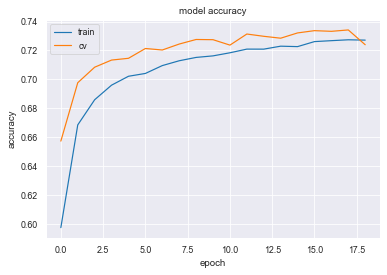

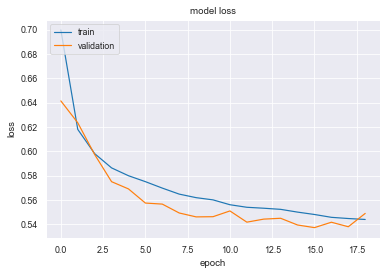

In [86]:
lstm_layer = LSTM(num_lstm,return_sequences=True,dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)
sequence_1_input = Input(shape=(1,300), dtype='float32')
print(sequence_1_input.shape)
x1 = lstm_layer(sequence_1_input)

sequence_2_input = Input(shape=(1,300), dtype='float32')
y1 = lstm_layer(sequence_2_input)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = LSTM(250,return_sequences=True)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer='nadam',
        metrics=['acc'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([X_train_1, X_train_2], y_train, 
                 validation_data=([X_cv_1, X_cv_2], y_cv), epochs=30, 
                 batch_size=2048, shuffle=True, callbacks=[early_stopping, model_checkpoint])
print(hist.history.keys())
#accuracy per epochs
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

# loss per epochs
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

In [87]:
result = model.evaluate([X_test_1,X_test_2],y_test)

90000/90000 [==============================] - 30s 331us/step


In [88]:
result

[0.5374683747079637, 0.7341111302375793]

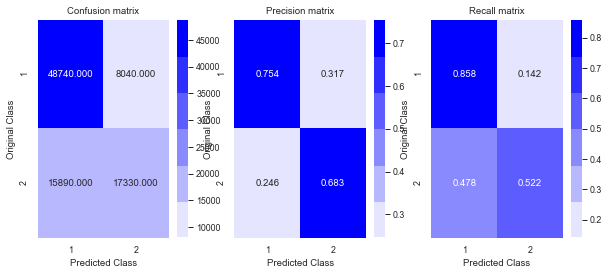

In [89]:
Y_pred = model.predict([X_test_1,X_test_2])

output_pred = []
output_orig = []
for i in range(len(Y_pred)):
    if(Y_pred[i][0][0] > 0.5):
        output_pred.append(1)
    else:
        output_pred.append(0)
    output_orig.append(y_test[i][0][0])
    
plot_confusion_matrix(output_orig,output_pred)

<h2  style = "color:blue">11. LSTM with an Embedding layer </b>

In [54]:
STAMP2 = 'lstm2_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
        rate_drop_dense)

In [55]:
#https://stackoverflow.com/a/22259008/4084039
#size of data is reduced to 200000 due to limitations of system configuration.Also the  data is sampled randomly.
# columns  = list(df_features.columns)
len_data =  data_frame.shape[0]
sample_size = 300000 #desired sample size
skipped_data = sorted(random.sample(range(1 , len_data + 1) , len_data - sample_size))

print("Number of rows  :", len_data)
print("Number of rows to be eliminated :",len(skipped_data))

data_frame = pd.read_csv('DATA/train.csv', skiprows = skipped_data)
print("Data size after sampling",data_frame.shape)

Number of rows  : 404290
Number of rows to be eliminated : 104290
Data size after sampling (300000, 6)


In [56]:
y = data_frame['is_duplicate']
X_train,X_test, y_train, y_test = train_test_split(data_frame, y , stratify=y, test_size=0.2,random_state=100)

In [57]:
with open('../../glove_vectors', 'rb') as f:
    Model1 = pickle.load(f)
    model_keys =  set(Model1.keys())

In [58]:
MAX_SEQUENCE_LENGTH = 30
MAX_VOCAB_SIZE = 200000
EMBEDDING_DIM = 300
num_lstm = 180
num_dense = 150
rate_drop_lstm = 0.178
rate_drop_dense = 0.171

In [60]:
question1_tr = list(X_train["question1"].apply(preprocessing))
question2_tr = list(X_train["question2"].apply(preprocessing))
question1_te = list(X_test["question1"].apply(preprocessing))
question2_te = list(X_test["question2"].apply(preprocessing))

print(type(question1_tr))

tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(question1_tr + question2_tr + question1_te + question2_te)

q_1 = tokenizer.texts_to_sequences(question1_tr)
q_2 = tokenizer.texts_to_sequences(question2_tr)
q_1_te = tokenizer.texts_to_sequences(question1_te)
q_2_te = tokenizer.texts_to_sequences(question2_te)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))
vocab_size = min(MAX_VOCAB_SIZE, len(word_index))+1


train_data_1 = pad_sequences(q_1, maxlen=MAX_SEQUENCE_LENGTH)
train_data_2 = pad_sequences(q_2, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', train_data_1.shape)

test_data_1 = pad_sequences(q_1_te, maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(q_2_te, maxlen=MAX_SEQUENCE_LENGTH)


embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in model_keys:
        embedding_matrix[i] = Model1[word]

<class 'list'>
Found 75964 unique tokens
Shape of data tensor: (240000, 30)


In [62]:
# print(train_data_1.shape)
train_data_1 = train_data_1.reshape((train_data_1.shape[0], 1, train_data_1.shape[1]))
train_data_2 = train_data_2.reshape((train_data_2.shape[0], 1, train_data_2.shape[1]))

test_data_1 = test_data_1.reshape((test_data_1.shape[0], 1, test_data_1.shape[1]))
test_data_2 = test_data_2.reshape((test_data_2.shape[0], 1, test_data_2.shape[1]))

y_train = y_train.values.reshape((y_train.shape[0],1,1))
y_test = y_test.values.reshape((y_test.shape[0],1,1))

print(train_data_1.shape)
test_data_1.shape

(240000, 1, 30)


(60000, 1, 30)

In [63]:
print(train_data_1.shape)
print(y_train.shape)
print(embedding_matrix.shape)
print(y_test.shape)

(240000, 1, 30)
(240000, 1, 1)
(75965, 300)
(60000, 1, 1)


(None, 1, 30)
(None, 1, 9000)
Train on 240000 samples, validate on 60000 samples
Epoch 1/30
240000/240000 [==============================] - 342s 1ms/step - loss: 0.5550 - acc: 0.7124 - val_loss: 0.6198 - val_acc: 0.7217
Epoch 2/30
240000/240000 [==============================] - 314s 1ms/step - loss: 0.4639 - acc: 0.7713 - val_loss: 0.5316 - val_acc: 0.7381
Epoch 3/30
240000/240000 [==============================] - 317s 1ms/step - loss: 0.4087 - acc: 0.8037 - val_loss: 0.4668 - val_acc: 0.7706
Epoch 4/30
240000/240000 [==============================] - 312s 1ms/step - loss: 0.3615 - acc: 0.8293 - val_loss: 0.4814 - val_acc: 0.7780
Epoch 5/30
240000/240000 [==============================] - 313s 1ms/step - loss: 0.3216 - acc: 0.8510 - val_loss: 0.4770 - val_acc: 0.7894
Epoch 6/30
240000/240000 [==============================] - 314s 1ms/step - loss: 0.2900 - acc: 0.8683 - val_loss: 0.5179 - val_acc: 0.7801
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


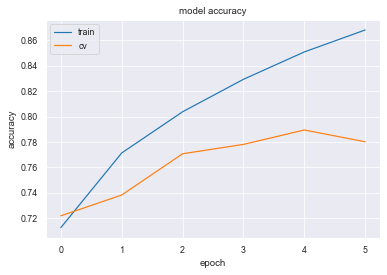

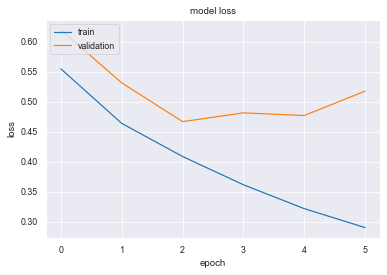

In [64]:
embedding_layer = Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=(1,MAX_SEQUENCE_LENGTH),
                            trainable=False)
lstm_layer = LSTM(num_lstm,return_sequences=True,dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

sequence_1_input = Input(shape=(1,MAX_SEQUENCE_LENGTH,), dtype='int32')
print(sequence_1_input.shape)
embedded_sequences_1 = embedding_layer(sequence_1_input)
embedded_sequences_1 = Reshape((1,30*300))(embedded_sequences_1)
print(embedded_sequences_1.shape)
x1 = lstm_layer(embedded_sequences_1)

sequence_2_input = Input(shape=(1,MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
embedded_sequences_2 = Reshape((1,30*300))(embedded_sequences_2)
y1 = lstm_layer(embedded_sequences_2)

merged = concatenate([x1, y1])
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = LSTM(250,return_sequences=True)(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = BatchNormalization()(merged)

merged = Dense(num_dense, activation=act)(merged)
# merged = Dropout(rate_drop_dense)(merged)
# merged = BatchNormalization()(merged)

preds = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input], \
        outputs=preds)
model.compile(loss='binary_crossentropy',optimizer='nadam',metrics=['acc'])

early_stopping =EarlyStopping(monitor='val_loss', patience=3)
bst_model_path = STAMP2 + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

hist = model.fit([train_data_1, train_data_2], y_train, validation_data=([test_data_1, test_data_2], y_test),
                 epochs=30,batch_size=2048, shuffle=True, callbacks=[early_stopping,model_checkpoint])
print(hist.history.keys())
#accuracy per epochs
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.show()

# loss per epochs
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

model.load_weights(bst_model_path)
bst_val_score = min(hist.history['val_loss'])

In [65]:
result = model.evaluate([test_data_1,test_data_2],y_test)

60000/60000 [==============================] - 58s 970us/step


In [66]:
result

[0.46684102053642273, 0.7706166505813599]

In [67]:
Y_pred = model.predict([test_data_1,test_data_2])

In [68]:
output_pred = []
output_orig = []
for i in range(len(Y_pred)):
    if(Y_pred[i][0][0] > 0.5):
        output_pred.append(1)
    else:
        output_pred.append(0)
    output_orig.append(y_test[i][0][0])
       

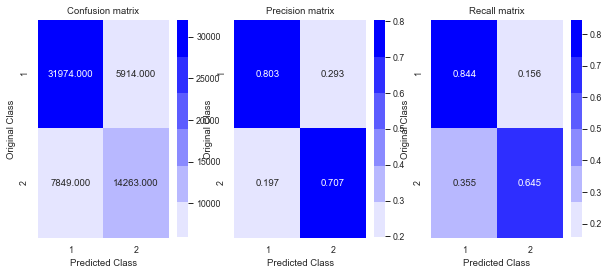

In [69]:
plot_confusion_matrix(output_orig,output_pred)